<a href="https://colab.research.google.com/github/taitip-supha/DeepLearn-Keras/blob/main/03_Sequence/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Prepar the Enviroment

In [ ]:
# List all NVIDIA GPUs as avaiable in this computer (or colub's session)
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-6acfbb78-cd9c-7879-e3c2-b269d971277c)


In [ ]:
#Import package
import sys,os,time,datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
%matplotlib inline
print(f"Python {sys.version}")
print(f"NumPy {np.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}")
gpus = tf.config.list_physical_devices('GPU')
print(f"Tensorflow detected : {len(gpus)} GPU(s)")
for i,gpu in enumerate(gpus):
  print(f" GPU No. {i} : Name = {gpu.name} , Type = {gpu.device_type}")


Python 3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]
NumPy 1.21.5
tf.keras.backend.image_data_format() = channels_last
Tensorflow detected : 1 GPU(s)
 GPU No. 0 : Name = /physical_device:GPU:0 , Type = GPU


In [ ]:
#Set fixed seeding values for reproducability during experiments
#to guarantee reproducability, make sure valuesfor any randomize poperation are all set
np.random.seed(1234)
tf.random.set_seed(5678)

# Ex1 Guess the next number (Simple RNN)
we use RNN to predict number of sequence of x_n = x_n-1 +2

## 1.1) Create the simple 1-layer RNN model

In [ ]:
my_rnn = tf.keras.models.Sequential()

#batch_size=None, time_steps=None, input_dim=1
#output from this layer is (batch_size,units) which equals to (batch_size,20)
my_rnn.add(tf.keras.layers.SimpleRNN(units=20, input_shape=(None,1)))

# Use the default 'linear activation'
my_rnn.add(tf.keras.layers.Dense(1))

my_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                440       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________


## 1.2) Create Train/val/test set using TimeseriesGenerator

In [ ]:
n_data = 200 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-400 -398 -396 -394 -392] , -390
1 : [-399 -397 -395 -393 -391] , -389
2 : [-398 -396 -394 -392 -390] , -388
3 : [-397 -395 -393 -391 -389] , -387
4 : [-396 -394 -392 -390 -388] , -386
-1 : [-201 -199 -197 -195 -193] , -191
-2 : [-202 -200 -198 -196 -194] , -192
-3 : [-203 -201 -199 -197 -195] , -193
-4 : [-204 -202 -200 -198 -196] , -194
-5 : [-205 -203 -201 -199 -197] , -195


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293
-1 : [-249 -247 -245 -243 -241] , -239
-2 : [-211 -209 -207 -205 -203] , -201
-3 : [-308 -306 -304 -302 -300] , -298
-4 : [-233 -231 -229 -227 -225] , -223
-5 : [-204 -202 -200 -198 -196] , -194


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

x_train, y_train = x[:n_train] , y[:n_train] 
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{x_train.shape}, y_train-shape:{y_train.shape}")
for i in range(5):
  print(f"{i} : {x_train[i]} , {y_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{x_val.shape}, y_val-shape:{y_val.shape}")
for i in range(5):
  print(f"{i} : {x_val[i]} , {y_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{x_test.shape}, y_test-shape:{y_test.shape}")
for i in range(5):
  print(f"{i} : {x_test[i]} , {y_test[i]}")


===== Train data =====
x_train-shape:(160, 5), y_train-shape:(160,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293

===== Validation data =====
x_val-shape:(20, 5), y_val-shape:(20,)
0 : [-324 -322 -320 -318 -316] , -314
1 : [-263 -261 -259 -257 -255] , -253
2 : [-230 -228 -226 -224 -222] , -220
3 : [-278 -276 -274 -272 -270] , -268
4 : [-329 -327 -325 -323 -321] , -319

===== Test data =====
x_test-shape:(20, 5), y_test-shape:(20,)
0 : [-394 -392 -390 -388 -386] , -384
1 : [-307 -305 -303 -301 -299] , -297
2 : [-373 -371 -369 -367 -365] , -363
3 : [-271 -269 -267 -265 -263] , -261
4 : [-248 -246 -244 -242 -240] , -238


In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

x_train_norm = minmax_norm.transform( x_train.reshape(-1,1)).reshape(-1,5)
y_train_norm = minmax_norm.transform( y_train.reshape(-1,1)).reshape(-1)

x_val_norm = minmax_norm.transform( x_val.reshape(-1,1)).reshape(-1,5)
y_val_norm = minmax_norm.transform( y_val.reshape(-1,1)).reshape(-1)

x_test_norm = minmax_norm.transform( x_test.reshape(-1,1)).reshape(-1,5)
y_test_norm = minmax_norm.transform( y_test.reshape(-1,1)).reshape(-1)


Dataset min-max: [-400.], [-193.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization =====")
print(f"x_train_norm:{x_train_norm.shape}, y_train_norm:{y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {x_train_norm[i]} , {y_train_norm[i]}")

print("\n===== Validation data after normalization =====")
print(f"x_val_norm:{x_val_norm.shape}, y_val_norm:{y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {x_val_norm[i]} , {y_val_norm[i]}")

print("\n===== Test data after normalization =====")
print(f"x_test_norm:{x_test_norm.shape}, y_test_norm:{y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {x_test_norm[i]} , {y_test_norm[i]}")



===== Train data after normalization =====
x_train_norm:(160, 5), y_train_norm:(160,)
0 : [0.14009662 0.14975845 0.15942029 0.16908213 0.17874396] , 0.18840579710144922
1 : [0.56521739 0.57487923 0.58454106 0.5942029  0.60386473] , 0.6135265700483092
2 : [0.33333333 0.34299517 0.352657   0.36231884 0.37198068] , 0.3816425120772946
3 : [0.84057971 0.85024155 0.85990338 0.86956522 0.87922705] , 0.8888888888888888
4 : [0.46859903 0.47826087 0.48792271 0.49758454 0.50724638] , 0.5169082125603865

===== Validation data after normalization =====
x_val_norm:(20, 5), y_val_norm:(20,)
0 : [0.36714976 0.37681159 0.38647343 0.39613527 0.4057971 ] , 0.4154589371980677
1 : [0.66183575 0.67149758 0.68115942 0.69082126 0.70048309] , 0.7101449275362319
2 : [0.82125604 0.83091787 0.84057971 0.85024155 0.85990338] , 0.8695652173913042
3 : [0.58937198 0.59903382 0.60869565 0.61835749 0.62801932] , 0.6376811594202898
4 : [0.34299517 0.352657   0.36231884 0.37198068 0.38164251] , 0.3913043478260869

=====

In [ ]:
# Add the third dimension of input_dim=1
x_train_norm  = x_train_norm[..., np.newaxis]
x_val_norm    = x_val_norm[..., np.newaxis]
x_test_norm   = x_test_norm[..., np.newaxis]

print("\nDimension after changed:")
print(f"x_train_norm : {x_train_norm.shape}")
print(f"x_val_norm : {x_val_norm.shape}")
print(f"x_test_norm : {x_test_norm.shape}")


Dimension after changed:
x_train_norm : (160, 5, 1)
x_val_norm : (20, 5, 1)
x_test_norm : (20, 5, 1)


In [ ]:
#Covert everything  to the defalt of float32

x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

## 1.3) Compile and Train the model

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# For regression, the loss can be used as the evaluation metric as well
my_rnn.compile(loss='mse', optimizer=adam, metrics=[])

checkpoint_filepath = "RNN_ex1_bestmodel_epoch{epoch:03d}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [ ]:
hist = my_rnn.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=300,
                  callbacks=[model_checkpoint_callback])

Epoch 1/300
3/3 [==============================] - 3s 126ms/step - loss: 0.9185 - val_loss: 0.6980
Epoch 2/300
3/3 [==============================] - 0s 27ms/step - loss: 0.6467 - val_loss: 0.4703
Epoch 3/300
3/3 [==============================] - 0s 29ms/step - loss: 0.4360 - val_loss: 0.2980
Epoch 4/300
3/3 [==============================] - 0s 25ms/step - loss: 0.2759 - val_loss: 0.1753
Epoch 5/300
3/3 [==============================] - 0s 26ms/step - loss: 0.1648 - val_loss: 0.0950
Epoch 6/300
3/3 [==============================] - 0s 26ms/step - loss: 0.0916 - val_loss: 0.0505
Epoch 7/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0509 - val_loss: 0.0332
Epoch 8/300
3/3 [==============================] - 0s 24ms/step - loss: 0.0361 - val_loss: 0.0332
Epoch 9/300
3/3 [==============================] - 0s 16ms/step - loss: 0.0351 - val_loss: 0.0402
Epoch 10/300
3/3 [==============================] - 0s 20ms/step - loss: 0.0395 - val_loss: 0.0461
Epoch 11/300
3/3 [

## 1.4) Evaluate the model

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('RNN_ex1_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : RNN_ex1_bestmodel_epoch298.hdf5


In [ ]:
my_rnn_best = tf.keras.models.load_model(bestmodel_file, compile=True)

In [ ]:
#Evaluate the model from last epoch
score = my_rnn.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(my_rnn.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(my_rnn.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 0.0007443480426445603)]


In [ ]:
#Evaluate the model from best epoch
score = my_rnn_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(my_rnn_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(my_rnn_best.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 0.0007851850241422653)]


## 1.5) Inference

In [ ]:
y1_test_predict = my_rnn.predict(x_test_norm)
y2_test_predict = my_rnn_best.predict(x_test_norm)

# Denormalize to raw value
y1_inv = minmax_norm.inverse_transform(y1_test_predict)
y2_inv = minmax_norm.inverse_transform(y2_test_predict)

In [ ]:
for i in range(10):
  print(f"x_test[{i}] = {x_test[i].reshape(1,-1)}, y_test[{i}] = {y_test[i]}, predict--> last_epoch({np.around(y1_inv[i])}) best_epoch({np.around(y2_inv[i])})")

x_test[0] = [[-394 -392 -390 -388 -386]], y_test[0] = -384, predict--> last_epoch([-390.]) best_epoch([-390.])
x_test[1] = [[-307 -305 -303 -301 -299]], y_test[1] = -297, predict--> last_epoch([-292.]) best_epoch([-292.])
x_test[2] = [[-373 -371 -369 -367 -365]], y_test[2] = -363, predict--> last_epoch([-365.]) best_epoch([-366.])
x_test[3] = [[-271 -269 -267 -265 -263]], y_test[3] = -261, predict--> last_epoch([-257.]) best_epoch([-258.])
x_test[4] = [[-248 -246 -244 -242 -240]], y_test[4] = -238, predict--> last_epoch([-237.]) best_epoch([-238.])
x_test[5] = [[-377 -375 -373 -371 -369]], y_test[5] = -367, predict--> last_epoch([-370.]) best_epoch([-370.])
x_test[6] = [[-206 -204 -202 -200 -198]], y_test[6] = -196, predict--> last_epoch([-207.]) best_epoch([-207.])
x_test[7] = [[-218 -216 -214 -212 -210]], y_test[7] = -208, predict--> last_epoch([-215.]) best_epoch([-215.])
x_test[8] = [[-266 -264 -262 -260 -258]], y_test[8] = -256, predict--> last_epoch([-252.]) best_epoch([-253.])
x

# Ex2 Guess the next number(Stacked RNN)

## 2.1 Create the deep RNN model

In [ ]:
ex2_rnn = tf.keras.models.Sequential()

# batch_size=None, time_steps=None, input_dim=1
ex2_rnn.add( tf.keras.layers.SimpleRNN(units=20, input_shape=(None,1), return_sequences=True) ) # RNN Layer 1st
ex2_rnn.add( tf.keras.layers.SimpleRNN(units=20, return_sequences=True) ) #RNN Layer 2nd
ex2_rnn.add( tf.keras.layers.SimpleRNN(units=10) ) #RNN layer 3

#Use the defult 'linear activation'
ex2_rnn.add( tf.keras.layers.Dense(1))

ex2_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,581
Trainable params: 1,581
Non-trainable params: 0
_________________________________________________________________


## 2.2 Create Train/val/test set using TimeseriesGenerator

In [ ]:
n_data = 200 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-400 -398 -396 -394 -392] , -390
1 : [-399 -397 -395 -393 -391] , -389
2 : [-398 -396 -394 -392 -390] , -388
3 : [-397 -395 -393 -391 -389] , -387
4 : [-396 -394 -392 -390 -388] , -386
-1 : [-201 -199 -197 -195 -193] , -191
-2 : [-202 -200 -198 -196 -194] , -192
-3 : [-203 -201 -199 -197 -195] , -193
-4 : [-204 -202 -200 -198 -196] , -194
-5 : [-205 -203 -201 -199 -197] , -195


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293
-1 : [-249 -247 -245 -243 -241] , -239
-2 : [-211 -209 -207 -205 -203] , -201
-3 : [-308 -306 -304 -302 -300] , -298
-4 : [-233 -231 -229 -227 -225] , -223
-5 : [-204 -202 -200 -198 -196] , -194


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

x_train, y_train = x[:n_train] , y[:n_train] 
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{x_train.shape}, y_train-shape:{y_train.shape}")
for i in range(5):
  print(f"{i} : {x_train[i]} , {y_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{x_val.shape}, y_val-shape:{y_val.shape}")
for i in range(5):
  print(f"{i} : {x_val[i]} , {y_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{x_test.shape}, y_test-shape:{y_test.shape}")
for i in range(5):
  print(f"{i} : {x_test[i]} , {y_test[i]}")


===== Train data =====
x_train-shape:(160, 5), y_train-shape:(160,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293

===== Validation data =====
x_val-shape:(20, 5), y_val-shape:(20,)
0 : [-324 -322 -320 -318 -316] , -314
1 : [-263 -261 -259 -257 -255] , -253
2 : [-230 -228 -226 -224 -222] , -220
3 : [-278 -276 -274 -272 -270] , -268
4 : [-329 -327 -325 -323 -321] , -319

===== Test data =====
x_test-shape:(20, 5), y_test-shape:(20,)
0 : [-394 -392 -390 -388 -386] , -384
1 : [-307 -305 -303 -301 -299] , -297
2 : [-373 -371 -369 -367 -365] , -363
3 : [-271 -269 -267 -265 -263] , -261
4 : [-248 -246 -244 -242 -240] , -238


In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

x_train_norm = minmax_norm.transform( x_train.reshape(-1,1)).reshape(-1,5)
y_train_norm = minmax_norm.transform( y_train.reshape(-1,1)).reshape(-1)

x_val_norm = minmax_norm.transform( x_val.reshape(-1,1)).reshape(-1,5)
y_val_norm = minmax_norm.transform( y_val.reshape(-1,1)).reshape(-1)

x_test_norm = minmax_norm.transform( x_test.reshape(-1,1)).reshape(-1,5)
y_test_norm = minmax_norm.transform( y_test.reshape(-1,1)).reshape(-1)


Dataset min-max: [-400.], [-193.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization =====")
print(f"x_train_norm:{x_train_norm.shape}, y_train_norm:{y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {x_train_norm[i]} , {y_train_norm[i]}")

print("\n===== Validation data after normalization =====")
print(f"x_val_norm:{x_val_norm.shape}, y_val_norm:{y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {x_val_norm[i]} , {y_val_norm[i]}")

print("\n===== Test data after normalization =====")
print(f"x_test_norm:{x_test_norm.shape}, y_test_norm:{y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {x_test_norm[i]} , {y_test_norm[i]}")



===== Train data after normalization =====
x_train_norm:(160, 5), y_train_norm:(160,)
0 : [0.14009662 0.14975845 0.15942029 0.16908213 0.17874396] , 0.18840579710144922
1 : [0.56521739 0.57487923 0.58454106 0.5942029  0.60386473] , 0.6135265700483092
2 : [0.33333333 0.34299517 0.352657   0.36231884 0.37198068] , 0.3816425120772946
3 : [0.84057971 0.85024155 0.85990338 0.86956522 0.87922705] , 0.8888888888888888
4 : [0.46859903 0.47826087 0.48792271 0.49758454 0.50724638] , 0.5169082125603865

===== Validation data after normalization =====
x_val_norm:(20, 5), y_val_norm:(20,)
0 : [0.36714976 0.37681159 0.38647343 0.39613527 0.4057971 ] , 0.4154589371980677
1 : [0.66183575 0.67149758 0.68115942 0.69082126 0.70048309] , 0.7101449275362319
2 : [0.82125604 0.83091787 0.84057971 0.85024155 0.85990338] , 0.8695652173913042
3 : [0.58937198 0.59903382 0.60869565 0.61835749 0.62801932] , 0.6376811594202898
4 : [0.34299517 0.352657   0.36231884 0.37198068 0.38164251] , 0.3913043478260869

=====

In [ ]:
# Add the third dimension of input_dim=1
x_train_norm  = x_train_norm[..., np.newaxis]
x_val_norm    = x_val_norm[..., np.newaxis]
x_test_norm   = x_test_norm[..., np.newaxis]

print("\nDimension after changed:")
print(f"x_train_norm : {x_train_norm.shape}")
print(f"x_val_norm : {x_val_norm.shape}")
print(f"x_test_norm : {x_test_norm.shape}")


Dimension after changed:
x_train_norm : (160, 5, 1)
x_val_norm : (20, 5, 1)
x_test_norm : (20, 5, 1)


In [ ]:
#Covert everything  to the defalt of float32

x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

## 2.3 Compile and train the model

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# For regression, the loss can be used as the evaluation metric as well
ex2_rnn.compile(loss='mse', optimizer=adam, metrics=[])

checkpoint_filepath = "RNN_ex2_bestmodel_epoch{epoch:03d}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [ ]:
hist_ex2 = ex2_rnn.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=300,
                  callbacks=[model_checkpoint_callback])

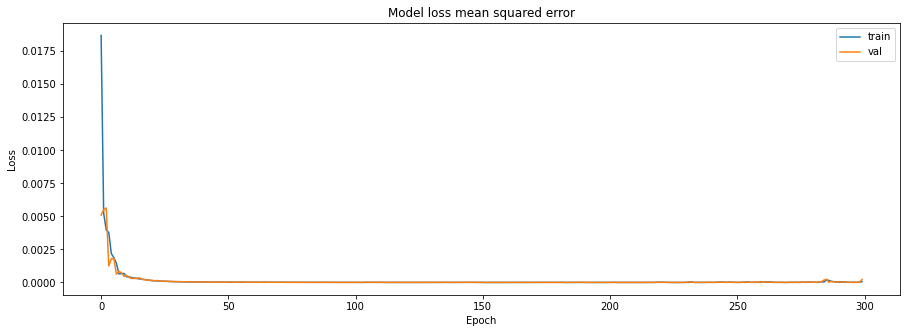

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex2.history['loss'])
plt.plot( hist_ex2.history['val_loss'])
plt.title('Model loss mean squared error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

## 2.4 Evaluate the model

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('RNN_ex2_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : RNN_ex2_bestmodel_epoch225.hdf5


In [ ]:
ex2_rnn_best = tf.keras.models.load_model(bestmodel_file, compile=True)

In [ ]:
#Evaluate the model from last epoch
score = ex2_rnn.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(ex2_rnn.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(ex2_rnn.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 0.00022981673828326166)]


In [ ]:
#Evaluate the model from best epoch
score = ex2_rnn_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(ex2_rnn_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(ex2_rnn_best.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 1.4474404679276631e-06)]


## 2.5 Inference

In [ ]:
y1_test_predict = ex2_rnn.predict(x_test_norm)
y2_test_predict = ex2_rnn_best.predict(x_test_norm)

# Denormalize to raw value
y1_inv = minmax_norm.inverse_transform(y1_test_predict)
y2_inv = minmax_norm.inverse_transform(y2_test_predict)

In [ ]:
for i in range(10):
  print(f"x_test[{i}] = {x_test[i].reshape(1,-1)}, y_test[{i}] = {y_test[i]}, predict--> last_epoch({np.around(y1_inv[i])}) best_epoch({np.around(y2_inv[i])})")

x_test[0] = [[-394 -392 -390 -388 -386]], y_test[0] = -384, predict--> last_epoch([-385.]) best_epoch([-384.])
x_test[1] = [[-307 -305 -303 -301 -299]], y_test[1] = -297, predict--> last_epoch([-300.]) best_epoch([-297.])
x_test[2] = [[-373 -371 -369 -367 -365]], y_test[2] = -363, predict--> last_epoch([-365.]) best_epoch([-363.])
x_test[3] = [[-271 -269 -267 -265 -263]], y_test[3] = -261, predict--> last_epoch([-264.]) best_epoch([-261.])
x_test[4] = [[-248 -246 -244 -242 -240]], y_test[4] = -238, predict--> last_epoch([-241.]) best_epoch([-238.])
x_test[5] = [[-377 -375 -373 -371 -369]], y_test[5] = -367, predict--> last_epoch([-369.]) best_epoch([-367.])
x_test[6] = [[-206 -204 -202 -200 -198]], y_test[6] = -196, predict--> last_epoch([-200.]) best_epoch([-196.])
x_test[7] = [[-218 -216 -214 -212 -210]], y_test[7] = -208, predict--> last_epoch([-211.]) best_epoch([-208.])
x_test[8] = [[-266 -264 -262 -260 -258]], y_test[8] = -256, predict--> last_epoch([-259.]) best_epoch([-256.])
x

## 2.6 Save to Drive

In [ ]:
#Save file best model to google drive
to_path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/{bestmodel_file}"
print(f"from : {bestmodel_file}")
print(f"to : {to_path}")
os.system(f"cp '{bestmodel_file}' '{to_path}'")

from : RNN_ex2_bestmodel_epoch225.hdf5
to : /content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/RNN_ex2_bestmodel_epoch225.hdf5


0

In [ ]:
#Save last epoch to google drive
to_path = f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/RNN_ex2_last_epoch.hdf5"
ex2_rnn.save(to_path)

# Ex3 Guess the next three number ( Apple from ex2)

*   Reuse the model of prediction the next number from example 2. Append one predicted number to input sequence, and feed the appended sequence back to the model to make another prediction repeatedly.
*   Becareful, denomalize and normalize y properly before appending it to the end of the x input sequence.



## 3.1 Create Train/val/test set using TimeseriesGenerator

In [ ]:
n_data = 200 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-400 -398 -396 -394 -392] , -390
1 : [-399 -397 -395 -393 -391] , -389
2 : [-398 -396 -394 -392 -390] , -388
3 : [-397 -395 -393 -391 -389] , -387
4 : [-396 -394 -392 -390 -388] , -386
-1 : [-201 -199 -197 -195 -193] , -191
-2 : [-202 -200 -198 -196 -194] , -192
-3 : [-203 -201 -199 -197 -195] , -193
-4 : [-204 -202 -200 -198 -196] , -194
-5 : [-205 -203 -201 -199 -197] , -195


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(200, 5), y-shape:(200,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293
-1 : [-249 -247 -245 -243 -241] , -239
-2 : [-211 -209 -207 -205 -203] , -201
-3 : [-308 -306 -304 -302 -300] , -298
-4 : [-233 -231 -229 -227 -225] , -223
-5 : [-204 -202 -200 -198 -196] , -194


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

x_train, y_train = x[:n_train] , y[:n_train] 
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{x_train.shape}, y_train-shape:{y_train.shape}")
for i in range(5):
  print(f"{i} : {x_train[i]} , {y_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{x_val.shape}, y_val-shape:{y_val.shape}")
for i in range(5):
  print(f"{i} : {x_val[i]} , {y_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{x_test.shape}, y_test-shape:{y_test.shape}")
for i in range(5):
  print(f"{i} : {x_test[i]} , {y_test[i]}")


===== Train data =====
x_train-shape:(160, 5), y_train-shape:(160,)
0 : [-371 -369 -367 -365 -363] , -361
1 : [-283 -281 -279 -277 -275] , -273
2 : [-331 -329 -327 -325 -323] , -321
3 : [-226 -224 -222 -220 -218] , -216
4 : [-303 -301 -299 -297 -295] , -293

===== Validation data =====
x_val-shape:(20, 5), y_val-shape:(20,)
0 : [-324 -322 -320 -318 -316] , -314
1 : [-263 -261 -259 -257 -255] , -253
2 : [-230 -228 -226 -224 -222] , -220
3 : [-278 -276 -274 -272 -270] , -268
4 : [-329 -327 -325 -323 -321] , -319

===== Test data =====
x_test-shape:(20, 5), y_test-shape:(20,)
0 : [-394 -392 -390 -388 -386] , -384
1 : [-307 -305 -303 -301 -299] , -297
2 : [-373 -371 -369 -367 -365] , -363
3 : [-271 -269 -267 -265 -263] , -261
4 : [-248 -246 -244 -242 -240] , -238


In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

x_train_norm = minmax_norm.transform( x_train.reshape(-1,1)).reshape(-1,5)
y_train_norm = minmax_norm.transform( y_train.reshape(-1,1)).reshape(-1)

x_val_norm = minmax_norm.transform( x_val.reshape(-1,1)).reshape(-1,5)
y_val_norm = minmax_norm.transform( y_val.reshape(-1,1)).reshape(-1)

x_test_norm = minmax_norm.transform( x_test.reshape(-1,1)).reshape(-1,5)
y_test_norm = minmax_norm.transform( y_test.reshape(-1,1)).reshape(-1)


Dataset min-max: [-400.], [-193.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization =====")
print(f"x_train_norm:{x_train_norm.shape}, y_train_norm:{y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {x_train_norm[i]} , {y_train_norm[i]}")

print("\n===== Validation data after normalization =====")
print(f"x_val_norm:{x_val_norm.shape}, y_val_norm:{y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {x_val_norm[i]} , {y_val_norm[i]}")

print("\n===== Test data after normalization =====")
print(f"x_test_norm:{x_test_norm.shape}, y_test_norm:{y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {x_test_norm[i]} , {y_test_norm[i]}")



===== Train data after normalization =====
x_train_norm:(160, 5), y_train_norm:(160,)
0 : [0.14009662 0.14975845 0.15942029 0.16908213 0.17874396] , 0.18840579710144922
1 : [0.56521739 0.57487923 0.58454106 0.5942029  0.60386473] , 0.6135265700483092
2 : [0.33333333 0.34299517 0.352657   0.36231884 0.37198068] , 0.3816425120772946
3 : [0.84057971 0.85024155 0.85990338 0.86956522 0.87922705] , 0.8888888888888888
4 : [0.46859903 0.47826087 0.48792271 0.49758454 0.50724638] , 0.5169082125603865

===== Validation data after normalization =====
x_val_norm:(20, 5), y_val_norm:(20,)
0 : [0.36714976 0.37681159 0.38647343 0.39613527 0.4057971 ] , 0.4154589371980677
1 : [0.66183575 0.67149758 0.68115942 0.69082126 0.70048309] , 0.7101449275362319
2 : [0.82125604 0.83091787 0.84057971 0.85024155 0.85990338] , 0.8695652173913042
3 : [0.58937198 0.59903382 0.60869565 0.61835749 0.62801932] , 0.6376811594202898
4 : [0.34299517 0.352657   0.36231884 0.37198068 0.38164251] , 0.3913043478260869

=====

In [ ]:
# Add the third dimension of input_dim=1
x_train_norm  = x_train_norm[..., np.newaxis]
x_val_norm    = x_val_norm[..., np.newaxis]
x_test_norm   = x_test_norm[..., np.newaxis]

print("\nDimension after changed:")
print(f"x_train_norm : {x_train_norm.shape}")
print(f"x_val_norm : {x_val_norm.shape}")
print(f"x_test_norm : {x_test_norm.shape}")


Dimension after changed:
x_train_norm : (160, 5, 1)
x_val_norm : (20, 5, 1)
x_test_norm : (20, 5, 1)


In [ ]:
#Covert everything  to the defalt of float32

x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

## 3.2 load model form ex2

In [ ]:
bestmodel_file = "RNN_ex2_bestmodel_epoch225.hdf5"
lastepoch_file = "RNN_ex2_last_epoch.hdf5"
ex2_rnn_best = tf.keras.models.load_model(f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/{bestmodel_file}", compile=True)
ex2_rnn_last = tf.keras.models.load_model(f"/content/drive/MyDrive/Colab Notebooks/BADS7604_DL/data/{lastepoch_file}", compile=True)

## 3.3 Inferene

In [ ]:
# how many steps ahead to predict numbers
n_steps = 3

In [ ]:
# Show resuts for the first 20 data in test set
for i in range(20):
  x_norm = np.copy(x_test_norm[i]).reshape(1,-1,1)

  #Predict n_steps ahead
  for step in range(n_steps):
    y_pred_norm = ex2_rnn_best.predict(x_norm)
    #Concatenate y_pred_norm to the end of x_norm
    x_norm = np.concatenate( [x_norm, y_pred_norm.reshape(1,1,1)], axis=1)

  # Denormailze
  x = minmax_norm.inverse_transform(x_norm.reshape(1,-1))
  print(f"x_test[{i}] = {x_test[i]}, Predicted-{np.around(x[0,-n_steps:])}")



x_test[0] = [-394 -392 -390 -388 -386], Predicted-[-384. -392. -379.]
x_test[1] = [-307 -305 -303 -301 -299], Predicted-[-297. -368. -243.]
x_test[2] = [-373 -371 -369 -367 -365], Predicted-[-363. -400. -335.]
x_test[3] = [-271 -269 -267 -265 -263], Predicted-[-261. -346. -214.]
x_test[4] = [-248 -246 -244 -242 -240], Predicted-[-238. -334. -198.]
x_test[5] = [-377 -375 -373 -371 -369], Predicted-[-367. -399. -343.]
x_test[6] = [-206 -204 -202 -200 -198], Predicted-[-196. -316. -173.]
x_test[7] = [-218 -216 -214 -212 -210], Predicted-[-208. -320. -180.]
x_test[8] = [-266 -264 -262 -260 -258], Predicted-[-256. -343. -211.]
x_test[9] = [-391 -389 -387 -385 -383], Predicted-[-381. -394. -372.]
x_test[10] = [-328 -326 -324 -322 -320], Predicted-[-318. -382. -265.]
x_test[11] = [-316 -314 -312 -310 -308], Predicted-[-306. -374. -252.]
x_test[12] = [-318 -316 -314 -312 -310], Predicted-[-308. -376. -254.]
x_test[13] = [-286 -284 -282 -280 -278], Predicted-[-276. -355. -226.]
x_test[14] = [-3

# Ex4 Guess the next three number ( output = 3)

## 4.1 Create the deep RNN model

In [ ]:
ex4_rnn = tf.keras.models.Sequential()
# batch_size=None, time_steps=None, input_dim=1
ex4_rnn.add( tf.keras.layers.SimpleRNN(units=20, input_shape=(None,1), return_sequences=True) ) # RNN Layer 1st
ex4_rnn.add( tf.keras.layers.SimpleRNN(units=20, return_sequences=True) ) #RNN Layer 2nd
ex4_rnn.add( tf.keras.layers.SimpleRNN(units=10) ) #RNN layer 3
#Use the defult 'linear activation'
ex4_rnn.add( tf.keras.layers.Dense(3))

ex4_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 20)          440       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                310       
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 1,603
Trainable params: 1,603
Non-trainable params: 0
_________________________________________________________________


## 4.2 Prepare data with three-step output

In [ ]:
n_data = 2000 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-4000 -3998 -3996 -3994 -3992] , -3990
1 : [-3999 -3997 -3995 -3993 -3991] , -3989
2 : [-3998 -3996 -3994 -3992 -3990] , -3988
3 : [-3997 -3995 -3993 -3991 -3989] , -3987
4 : [-3996 -3994 -3992 -3990 -3988] , -3986
-1 : [-2001 -1999 -1997 -1995 -1993] , -1991
-2 : [-2002 -2000 -1998 -1996 -1994] , -1992
-3 : [-2003 -2001 -1999 -1997 -1995] , -1993
-4 : [-2004 -2002 -2000 -1998 -1996] , -1994
-5 : [-2005 -2003 -2001 -1999 -1997] , -1995


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-3033 -3031 -3029 -3027 -3025] , -3023
1 : [-3372 -3370 -3368 -3366 -3364] , -3362
2 : [-3423 -3421 -3419 -3417 -3415] , -3413
3 : [-3911 -3909 -3907 -3905 -3903] , -3901
4 : [-2829 -2827 -2825 -2823 -2821] , -2819
-1 : [-2825 -2823 -2821 -2819 -2817] , -2815
-2 : [-3811 -3809 -3807 -3805 -3803] , -3801
-3 : [-3140 -3138 -3136 -3134 -3132] , -3130
-4 : [-2744 -2742 -2740 -2738 -2736] , -2734
-5 : [-2809 -2807 -2805 -2803 -2801] , -2799


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

x_train, y_train = x[:n_train] , y[:n_train] 
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{x_train.shape}, y_train-shape:{y_train.shape}")
for i in range(5):
  print(f"{i} : {x_train[i]} , {y_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{x_val.shape}, y_val-shape:{y_val.shape}")
for i in range(5):
  print(f"{i} : {x_val[i]} , {y_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{x_test.shape}, y_test-shape:{y_test.shape}")
for i in range(5):
  print(f"{i} : {x_test[i]} , {y_test[i]}")


===== Train data =====
x_train-shape:(1600, 5), y_train-shape:(1600,)
0 : [-3033 -3031 -3029 -3027 -3025] , -3023
1 : [-3372 -3370 -3368 -3366 -3364] , -3362
2 : [-3423 -3421 -3419 -3417 -3415] , -3413
3 : [-3911 -3909 -3907 -3905 -3903] , -3901
4 : [-2829 -2827 -2825 -2823 -2821] , -2819

===== Validation data =====
x_val-shape:(200, 5), y_val-shape:(200,)
0 : [-3200 -3198 -3196 -3194 -3192] , -3190
1 : [-3488 -3486 -3484 -3482 -3480] , -3478
2 : [-2285 -2283 -2281 -2279 -2277] , -2275
3 : [-3846 -3844 -3842 -3840 -3838] , -3836
4 : [-2724 -2722 -2720 -2718 -2716] , -2714

===== Test data =====
x_test-shape:(200, 5), y_test-shape:(200,)
0 : [-2126 -2124 -2122 -2120 -2118] , -2116
1 : [-3343 -3341 -3339 -3337 -3335] , -3333
2 : [-3710 -3708 -3706 -3704 -3702] , -3700
3 : [-3995 -3993 -3991 -3989 -3987] , -3985
4 : [-2885 -2883 -2881 -2879 -2877] , -2875


Instead of one-step outputs (x[i] = [2,4,6,8,10], yi[12] but model request x[i] = [2,4,6,8,10], yi[12,14,16] 

In [ ]:
#Create three array
y_train_temp = np.zeros( (y_train.shape[0],3), dtype=np.float32)
y_test_temp = np.zeros( (y_test.shape[0],3), dtype=np.float32)
y_val_temp = np.zeros( (y_val.shape[0],3), dtype=np.float32)

#Copy original value to vector
y_train_temp[:,0] = y_train[:]
y_test_temp[:,0] = y_test[:]
y_val_temp[:,0] = y_val[:]

In [ ]:
# Compute values for the 1stand 2nd columns of each array
for i in range(2):
  y_train_temp[:,i+1] = y_train_temp[:,i] +2
  y_test_temp[:,i+1] = y_test_temp[:,i] +2
  y_val_temp[:,i+1] = y_val_temp[:,i] +2

In [ ]:
# Preview Before-After result
print(f"\n========== y_train ==========")
print(f"Shape before:{y_train.shape} after:{y_train_temp.shape}")
print(f"Example befor : {y_train[0]} , after ; {y_train_temp[0]}")

print(f"\n========== y_test ==========")
print(f"Shape before:{y_test.shape} after:{y_test_temp.shape}")
print(f"Example befor : {y_test[0]} , after ; {y_test_temp[0]}")

print(f"\n========== y_val ==========")
print(f"Shape before:{y_val.shape} after:{y_val_temp.shape}")
print(f"Example befor : {y_val[0]} , after ; {y_val_temp[0]}")


========== y_train ==========
Shape before:(1600,) after:(1600, 3)
Example befor : -3023 , after ; [-3023. -3021. -3019.]

========== y_test ==========
Shape before:(200,) after:(200, 3)
Example befor : -2116 , after ; [-2116. -2114. -2112.]

========== y_val ==========
Shape before:(200,) after:(200, 3)
Example befor : -3190 , after ; [-3190. -3188. -3186.]


In [ ]:
#Reassign the new array shape to original y_train y_test y_val
y_train = y_train_temp
y_test = y_test_temp
y_val = y_val_temp

In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

x_train_norm = minmax_norm.transform( x_train.reshape(-1,1)).reshape(-1,5)
y_train_norm = minmax_norm.transform( y_train.reshape(-1,1)).reshape(-1,3)

x_val_norm = minmax_norm.transform( x_val.reshape(-1,1)).reshape(-1,5)
y_val_norm = minmax_norm.transform( y_val.reshape(-1,1)).reshape(-1,3)

x_test_norm = minmax_norm.transform( x_test.reshape(-1,1)).reshape(-1,5)
y_test_norm = minmax_norm.transform( y_test.reshape(-1,1)).reshape(-1,3)


Dataset min-max: [-4000.], [-1993.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization =====")
print(f"x_train_norm:{x_train_norm.shape}, y_train_norm:{y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {x_train_norm[i]} , {y_train_norm[i]}")

print("\n===== Validation data after normalization =====")
print(f"x_val_norm:{x_val_norm.shape}, y_val_norm:{y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {x_val_norm[i]} , {y_val_norm[i]}")

print("\n===== Test data after normalization =====")
print(f"x_test_norm:{x_test_norm.shape}, y_test_norm:{y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {x_test_norm[i]} , {y_test_norm[i]}")



===== Train data after normalization =====
x_train_norm:(1600, 5), y_train_norm:(1600, 3)
0 : [0.48181365 0.48281016 0.48380668 0.48480319 0.4857997 ] , [0.4867962  0.48779267 0.48878926]
1 : [0.31290483 0.31390135 0.31489786 0.31589437 0.31689088] , [0.31788737 0.31888396 0.31988043]
2 : [0.28749377 0.28849028 0.2894868  0.29048331 0.29147982] , [0.29247636 0.29347283 0.2944693 ]
3 : [0.04434479 0.04534131 0.04633782 0.04733433 0.04833084] , [0.04932732 0.05032391 0.05132038]
4 : [0.5834579  0.58445441 0.58545092 0.58644743 0.58744395] , [0.5884405  0.58943695 0.5904334 ]

===== Validation data after normalization =====
x_val_norm:(200, 5), y_val_norm:(200, 3)
0 : [0.39860488 0.3996014  0.40059791 0.40159442 0.40259093] , [0.4035874  0.404584   0.40558046]
1 : [0.25510713 0.25610364 0.25710015 0.25809666 0.25909317] , [0.2600897  0.26108617 0.26208276]
2 : [0.85450922 0.85550573 0.85650224 0.85749875 0.85849527] , [0.85949177 0.86048824 0.8614848 ]
3 : [0.07673144 0.07772795 0.078724

In [ ]:
# Add the third dimension of input_dim=1
x_train_norm  = x_train_norm[..., np.newaxis]
x_val_norm    = x_val_norm[..., np.newaxis]
x_test_norm   = x_test_norm[..., np.newaxis]

print("\nDimension after changed:")
print(f"x_train_norm : {x_train_norm.shape}")
print(f"x_val_norm : {x_val_norm.shape}")
print(f"x_test_norm : {x_test_norm.shape}")


Dimension after changed:
x_train_norm : (1600, 5, 1)
x_val_norm : (200, 5, 1)
x_test_norm : (200, 5, 1)


In [ ]:
#Covert everything  to the defalt of float32

x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

## 4.3 Compile and train the model

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# For regression, the loss can be used as the evaluation metric as well
ex4_rnn.compile(loss='mse', optimizer=adam, metrics=[])

checkpoint_filepath = "RNN_ex4_bestmodel_epoch{epoch:03d}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [ ]:
hist_ex4 = ex4_rnn.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=300,
                  callbacks=[model_checkpoint_callback])

Epoch 1/300
25/25 [==============================] - 5s 34ms/step - loss: 0.1498 - val_loss: 0.0173
Epoch 2/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0169 - val_loss: 0.0090
Epoch 3/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 4/300
25/25 [==============================] - 0s 13ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 5/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0029
Epoch 6/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 7/300
25/25 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 8/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 8.4898

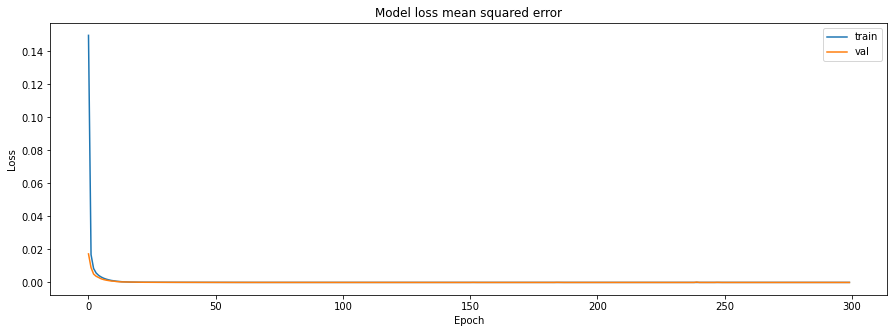

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex4.history['loss'])
plt.plot( hist_ex4.history['val_loss'])
plt.title('Model loss mean squared error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

## 4.4 Evaluate the model

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('RNN_ex4_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : RNN_ex4_bestmodel_epoch266.hdf5


In [ ]:
ex4_rnn_best = tf.keras.models.load_model(bestmodel_file, compile=True)

In [ ]:
#Evaluate the model from last epoch
score = ex4_rnn.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(ex4_rnn.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(ex4_rnn.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 4.817316494154511e-06)]


In [ ]:
#Evaluate the model from best epoch
score = ex4_rnn_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(ex4_rnn_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(ex4_rnn_best.metrics_names[0],score)]}")

Test results (model from the best epoch) :[('loss', 9.596348036211566e-07)]


## 4.5 Inference

In [ ]:
y1_test_predict = ex4_rnn.predict(x_test_norm)
y2_test_predict = ex4_rnn_best.predict(x_test_norm)

# Denormalize to raw value
y1_inv = minmax_norm.inverse_transform(y1_test_predict)
y2_inv = minmax_norm.inverse_transform(y2_test_predict)

In [ ]:
for i in range(10):
  print(f"x_test[{i}] = {x_test[i].reshape(1,-1)}, y_test[{i}] = {y_test[i]}, predict--> last_epoch({np.around(y1_inv[i])}) best_epoch({np.around(y2_inv[i])})")

x_test[0] = [[-2126 -2124 -2122 -2120 -2118]], y_test[0] = [-2116. -2114. -2112.], predict--> last_epoch([-2111. -2117. -2110.]) best_epoch([-2117. -2116. -2112.])
x_test[1] = [[-3343 -3341 -3339 -3337 -3335]], y_test[1] = [-3333. -3331. -3329.], predict--> last_epoch([-3326. -3333. -3326.]) best_epoch([-3332. -3332. -3326.])
x_test[2] = [[-3710 -3708 -3706 -3704 -3702]], y_test[2] = [-3700. -3698. -3696.], predict--> last_epoch([-3695. -3699. -3697.]) best_epoch([-3701. -3697. -3698.])
x_test[3] = [[-3995 -3993 -3991 -3989 -3987]], y_test[3] = [-3985. -3983. -3981.], predict--> last_epoch([-3977. -3985. -3973.]) best_epoch([-3983. -3987. -3975.])
x_test[4] = [[-2885 -2883 -2881 -2879 -2877]], y_test[4] = [-2875. -2873. -2871.], predict--> last_epoch([-2870. -2877. -2871.]) best_epoch([-2875. -2876. -2871.])
x_test[5] = [[-2148 -2146 -2144 -2142 -2140]], y_test[5] = [-2138. -2136. -2134.], predict--> last_epoch([-2132. -2139. -2132.]) best_epoch([-2138. -2137. -2134.])
x_test[6] = [[-3

# Ex5 Guess the next three number (containing output in each step)

## 5.1 Create the deep RNN model

In [ ]:
ex5_rnn = tf.keras.models.Sequential()

# batch_size=None, time_steps=None, input_dim=1
# >> output of RNN is (batch_size, units)=(batch_size,10)
ex5_rnn.add( tf.keras.layers.SimpleRNN(units=20, input_shape=(None,1), return_sequences=True) ) # RNN Layer 1st
ex5_rnn.add( tf.keras.layers.SimpleRNN(units=20, return_sequences=True) ) #RNN Layer 2nd
ex5_rnn.add( tf.keras.layers.SimpleRNN(units=10, return_sequences=True) ) #RNN layer 3 /output prediction of all time step
#Use the defult 'linear activation'
ex5_rnn.add( tf.keras.layers.TimeDistributed( tf.keras.layers.Dense(3) ) )

ex5_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 20)          820       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, None, 10)          310       
                                                                 
 time_distributed (TimeDistr  (None, None, 3)          33        
 ibuted)                                                         
                                                                 
Total params: 1,603
Trainable params: 1,603
Non-trainable params: 0
_________________________________________________________________


## 5.2 Prepare data with three-step outputs for all time step

In [ ]:
n_data = 2000 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-4000 -3998 -3996 -3994 -3992] , -3990
1 : [-3999 -3997 -3995 -3993 -3991] , -3989
2 : [-3998 -3996 -3994 -3992 -3990] , -3988
3 : [-3997 -3995 -3993 -3991 -3989] , -3987
4 : [-3996 -3994 -3992 -3990 -3988] , -3986
-1 : [-2001 -1999 -1997 -1995 -1993] , -1991
-2 : [-2002 -2000 -1998 -1996 -1994] , -1992
-3 : [-2003 -2001 -1999 -1997 -1995] , -1993
-4 : [-2004 -2002 -2000 -1998 -1996] , -1994
-5 : [-2005 -2003 -2001 -1999 -1997] , -1995


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-3033 -3031 -3029 -3027 -3025] , -3023
1 : [-3372 -3370 -3368 -3366 -3364] , -3362
2 : [-3423 -3421 -3419 -3417 -3415] , -3413
3 : [-3911 -3909 -3907 -3905 -3903] , -3901
4 : [-2829 -2827 -2825 -2823 -2821] , -2819
-1 : [-2825 -2823 -2821 -2819 -2817] , -2815
-2 : [-3811 -3809 -3807 -3805 -3803] , -3801
-3 : [-3140 -3138 -3136 -3134 -3132] , -3130
-4 : [-2744 -2742 -2740 -2738 -2736] , -2734
-5 : [-2809 -2807 -2805 -2803 -2801] , -2799


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

x_train, y_train = x[:n_train] , y[:n_train] 
x_val, y_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
x_test, y_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{x_train.shape}, y_train-shape:{y_train.shape}")
for i in range(5):
  print(f"{i} : {x_train[i]} , {y_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{x_val.shape}, y_val-shape:{y_val.shape}")
for i in range(5):
  print(f"{i} : {x_val[i]} , {y_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{x_test.shape}, y_test-shape:{y_test.shape}")
for i in range(5):
  print(f"{i} : {x_test[i]} , {y_test[i]}")


===== Train data =====
x_train-shape:(1600, 5), y_train-shape:(1600,)
0 : [-3033 -3031 -3029 -3027 -3025] , -3023
1 : [-3372 -3370 -3368 -3366 -3364] , -3362
2 : [-3423 -3421 -3419 -3417 -3415] , -3413
3 : [-3911 -3909 -3907 -3905 -3903] , -3901
4 : [-2829 -2827 -2825 -2823 -2821] , -2819

===== Validation data =====
x_val-shape:(200, 5), y_val-shape:(200,)
0 : [-3200 -3198 -3196 -3194 -3192] , -3190
1 : [-3488 -3486 -3484 -3482 -3480] , -3478
2 : [-2285 -2283 -2281 -2279 -2277] , -2275
3 : [-3846 -3844 -3842 -3840 -3838] , -3836
4 : [-2724 -2722 -2720 -2718 -2716] , -2714

===== Test data =====
x_test-shape:(200, 5), y_test-shape:(200,)
0 : [-2126 -2124 -2122 -2120 -2118] , -2116
1 : [-3343 -3341 -3339 -3337 -3335] , -3333
2 : [-3710 -3708 -3706 -3704 -3702] , -3700
3 : [-3995 -3993 -3991 -3989 -3987] , -3985
4 : [-2885 -2883 -2881 -2879 -2877] , -2875


Instead of one-step outputs (x[i] = [2,4,6,8,10], yi[12] 
</br> but model request 
</br> x[i] = [2,4,6,8,10] 
</br> y[i] = [[4,6,8],[6,8,10],[8,10,12],[10,12,14],[12,14,16]]

In [ ]:
#Create three array each input's time_steps=5, output_dim=3
n_output_timesteps = 3
y_train_temp = np.zeros( (y_train.shape[0], n_input_timesteps, n_output_timesteps), dtype=np.float32)
y_test_temp = np.zeros( (y_test.shape[0], n_input_timesteps, n_output_timesteps), dtype=np.float32)
y_val_temp = np.zeros( (y_val.shape[0], n_input_timesteps, n_output_timesteps), dtype=np.float32)

#Fill the three new arrays with the first predicted numbers (for the last time step only)
y_train_temp[:,-1,0] = y_train[:]
y_test_temp[:,-1,0]  = y_test[:]
y_val_temp[:,-1,0]   = y_val[:]

print(f"Example data : \n{y_train_temp[0]}")


Example data : 
[[    0.     0.     0.]
 [    0.     0.     0.]
 [    0.     0.     0.]
 [    0.     0.     0.]
 [-3023.     0.     0.]]


In [ ]:
# For the last time step only,fill in tje second, third
for i in range(1,n_output_timesteps):
  y_train_temp[:,-1,i] = y_train_temp[:,-1,i-1] +2
  y_test_temp[:,-1,i]  = y_test_temp[:,-1,i-1] +2
  y_val_temp[:,-1,i]   = y_val_temp[:,-1,i-1] +2

print(f"Example data :\n {y_train_temp[0]}")

Example data :
 [[    0.     0.     0.]
 [    0.     0.     0.]
 [    0.     0.     0.]
 [    0.     0.     0.]
 [-3023. -3021. -3019.]]


In [ ]:
# For the remaining non-last time step, fill in values by referring to thire next timestep
for tm in range(n_input_timesteps-2,-1,-1):
  y_train_temp[:, tm, :] = y_train_temp[:, tm+1, :]-2
  y_test_temp[:, tm, :]  = y_test_temp[:, tm+1, :]-2
  y_val_temp[:, tm, :]   = y_val_temp[:, tm+1, :]-2

print(f"Example data :\n {y_train_temp[0]}")

Example data :
 [[-3031. -3029. -3027.]
 [-3029. -3027. -3025.]
 [-3027. -3025. -3023.]
 [-3025. -3023. -3021.]
 [-3023. -3021. -3019.]]


In [ ]:
# Preview Before-After result
print(f"\n========== y_train ==========")
print(f"Shape before:{y_train.shape} after:{y_train_temp.shape}")
print(f"Example \nbefor : {y_train[0]} , \nafter ; \n{y_train_temp[0]}")

print(f"\n========== y_test ==========")
print(f"Shape before:{y_test.shape} after:{y_test_temp.shape}")
print(f"Example \nbefor : {y_test[0]} , \nafter : \n{y_test_temp[0]}")

print(f"\n========== y_val ==========")
print(f"Shape before:{y_val.shape} after:{y_val_temp.shape}")
print(f"Example \nbefor : {y_val[0]} , \nafter ; \n{y_val_temp[0]}")


========== y_train ==========
Shape before:(1600,) after:(1600, 5, 3)
Example 
befor : -3023 , 
after ; 
[[-3031. -3029. -3027.]
 [-3029. -3027. -3025.]
 [-3027. -3025. -3023.]
 [-3025. -3023. -3021.]
 [-3023. -3021. -3019.]]

========== y_test ==========
Shape before:(200,) after:(200, 5, 3)
Example 
befor : -2116 , 
after : 
[[-2124. -2122. -2120.]
 [-2122. -2120. -2118.]
 [-2120. -2118. -2116.]
 [-2118. -2116. -2114.]
 [-2116. -2114. -2112.]]

========== y_val ==========
Shape before:(200,) after:(200, 5, 3)
Example 
befor : -3190 , 
after ; 
[[-3198. -3196. -3194.]
 [-3196. -3194. -3192.]
 [-3194. -3192. -3190.]
 [-3192. -3190. -3188.]
 [-3190. -3188. -3186.]]


In [ ]:
#Reassign the new array shape to original y_train y_test y_val
y_train = y_train_temp
y_test = y_test_temp
y_val = y_val_temp

In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

x_train_norm = minmax_norm.transform( x_train.reshape(-1,1)).reshape(-1,5)
y_train_norm = minmax_norm.transform( y_train.reshape(-1,1)).reshape(y_train.shape)

x_val_norm = minmax_norm.transform( x_val.reshape(-1,1)).reshape(-1,5)
y_val_norm = minmax_norm.transform( y_val.reshape(-1,1)).reshape(y_val.shape)

x_test_norm = minmax_norm.transform( x_test.reshape(-1,1)).reshape(-1,5)
y_test_norm = minmax_norm.transform( y_test.reshape(-1,1)).reshape(y_test.shape)


Dataset min-max: [-4000.], [-1993.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization =====")
print(f"x_train_norm:{x_train_norm.shape}, y_train_norm:{y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {x_train_norm[i]} , {y_train_norm[i]}")

print("\n===== Validation data after normalization =====")
print(f"x_val_norm:{x_val_norm.shape}, y_val_norm:{y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {x_val_norm[i]} , {y_val_norm[i]}")

print("\n===== Test data after normalization =====")
print(f"x_test_norm:{x_test_norm.shape}, y_test_norm:{y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {x_test_norm[i]} , {y_test_norm[i]}")



===== Train data after normalization =====
x_train_norm:(1600, 5), y_train_norm:(1600, 5, 3)
0 : [0.48181365 0.48281016 0.48380668 0.48480319 0.4857997 ] , [[0.4828102  0.48380667 0.48480314]
 [0.48380667 0.48480314 0.48579973]
 [0.48480314 0.48579973 0.4867962 ]
 [0.48579973 0.4867962  0.48779267]
 [0.4867962  0.48779267 0.48878926]]
1 : [0.31290483 0.31390135 0.31489786 0.31589437 0.31689088] , [[0.31390136 0.31489784 0.3158943 ]
 [0.31489784 0.3158943  0.3168909 ]
 [0.3158943  0.3168909  0.31788737]
 [0.3168909  0.31788737 0.31888396]
 [0.31788737 0.31888396 0.31988043]]
2 : [0.28749377 0.28849028 0.2894868  0.29048331 0.29147982] , [[0.28849024 0.28948683 0.2904833 ]
 [0.28948683 0.2904833  0.29147977]
 [0.2904833  0.29147977 0.29247636]
 [0.29147977 0.29247636 0.29347283]
 [0.29247636 0.29347283 0.2944693 ]]
3 : [0.04434479 0.04534131 0.04633782 0.04733433 0.04833084] , [[0.04534132 0.04633779 0.04733438]
 [0.04633779 0.04733438 0.04833085]
 [0.04733438 0.04833085 0.04932732]
 [0

In [ ]:
# Add the third dimension of input_dim=1
x_train_norm  = x_train_norm[..., np.newaxis]
x_val_norm    = x_val_norm[..., np.newaxis]
x_test_norm   = x_test_norm[..., np.newaxis]

print("\nDimension after changed:")
print(f"x_train_norm : {x_train_norm.shape}")
print(f"x_val_norm : {x_val_norm.shape}")
print(f"x_test_norm : {x_test_norm.shape}")


Dimension after changed:
x_train_norm : (1600, 5, 1)
x_val_norm : (200, 5, 1)
x_test_norm : (200, 5, 1)


In [ ]:
#Covert everything  to the defalt of float32

x_train_norm = x_train_norm.astype(np.float32)
y_train_norm = y_train_norm.astype(np.float32)
x_val_norm = x_val_norm.astype(np.float32)
y_val_norm = y_val_norm.astype(np.float32)
x_test_norm = x_test_norm.astype(np.float32)
y_test_norm = y_test_norm.astype(np.float32)

## 5.3 Compile and train the model

When trainin we use losses computed from all time step, but when evaluating we only use loss computed from the last step

In [ ]:
#create custom metric to judge the performance of out model
def last_time_step_mse(y_true, y_pred):
  return tf.keras.metrics.mean_squared_error( y_true[:, -1], y_pred[:, -1])

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# For regression, the loss can be used as the evaluation metric as well
ex5_rnn.compile(loss='mse', optimizer=adam, metrics=[last_time_step_mse])

checkpoint_filepath = "RNN_ex5_bestmodel_epoch{epoch:03d}.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

In [ ]:
hist_ex5 = ex5_rnn.fit(x_train_norm, y_train_norm,
                  validation_data=(x_val_norm, y_val_norm),
                  batch_size=64, epochs=300,
                  callbacks=[model_checkpoint_callback])

Epoch 1/300
25/25 [==============================] - 2s 26ms/step - loss: 0.2111 - last_time_step_mse: 0.1106 - val_loss: 0.0811 - val_last_time_step_mse: 0.0271
Epoch 2/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0567 - last_time_step_mse: 0.0250 - val_loss: 0.0307 - val_last_time_step_mse: 0.0106
Epoch 3/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0239 - last_time_step_mse: 0.0098 - val_loss: 0.0148 - val_last_time_step_mse: 0.0061
Epoch 4/300
25/25 [==============================] - 0s 13ms/step - loss: 0.0127 - last_time_step_mse: 0.0063 - val_loss: 0.0085 - val_last_time_step_mse: 0.0041
Epoch 5/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0080 - last_time_step_mse: 0.0042 - val_loss: 0.0058 - val_last_time_step_mse: 0.0026
Epoch 6/300
25/25 [==============================] - 0s 12ms/step - loss: 0.0058 - last_time_step_mse: 0.0030 - val_loss: 0.0043 - val_last_time_step_mse: 0.0020
Epoch 7/300
25/25 [=========

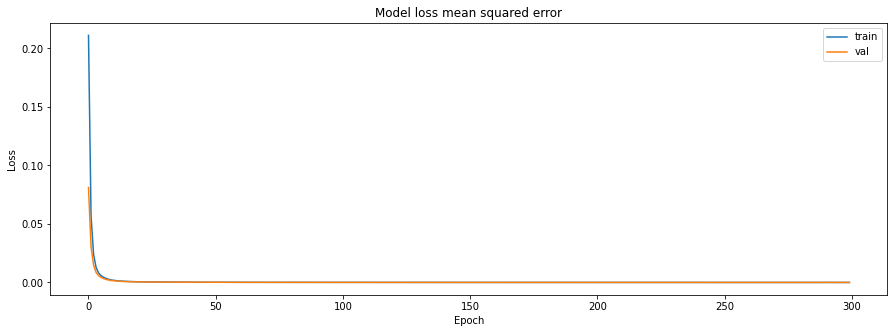

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex5.history['loss'])
plt.plot( hist_ex5.history['val_loss'])
plt.title('Model loss mean squared error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

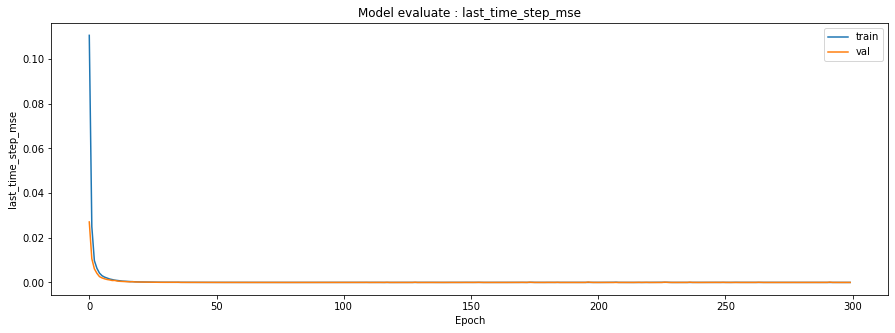

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex5.history['last_time_step_mse'])
plt.plot( hist_ex5.history['val_last_time_step_mse'])
plt.title('Model evaluate : last_time_step_mse')
plt.ylabel('last_time_step_mse')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

## 5.4 Evaluate the model

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('RNN_ex5_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : RNN_ex5_bestmodel_epoch299.hdf5


In [ ]:
ex5_rnn_best = tf.keras.models.load_model(bestmodel_file, compile=True 
                                          ,custom_objects={"last_time_step_mse":last_time_step_mse})

In [ ]:
#Evaluate the model from last epoch
score = ex5_rnn.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the last epoch) :{[(ex5_rnn.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(ex5_rnn.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 1.0543169992160983e-05), ('last_time_step_mse', 1.128229996538721e-05)]


In [ ]:
#Evaluate the model from best epoch
score = ex5_rnn_best.evaluate(x_test_norm, y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(ex5_rnn_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(ex5_rnn_best.metrics_names[0],score)]}")

Test results (model from the best epoch) :[('loss', 8.073094249994028e-06), ('last_time_step_mse', 1.4510791288557812e-06)]


## 5.5 Inference

In [ ]:
y1_test_predict = ex5_rnn.predict(x_test_norm)[:,-1,:]
y2_test_predict = ex5_rnn_best.predict(x_test_norm)[:,-1,:]

# Denormalize to raw value
y1_inv = minmax_norm.inverse_transform(y1_test_predict)
y2_inv = minmax_norm.inverse_transform(y2_test_predict)

In [ ]:
for i in range(10):
  print(f"x_test[{i}] = {x_test[i].reshape(-1)}, y_test[{i}] = {y_test[i][-1]}, predict--> last_epoch({np.around(y1_inv[i])}) best_epoch({np.around(y2_inv[i])})")

x_test[0] = [-2126 -2124 -2122 -2120 -2118], y_test[0] = [-2116. -2114. -2112.], predict--> last_epoch([-2112. -2109. -2100.]) best_epoch([-2112. -2112. -2114.])
x_test[1] = [-3343 -3341 -3339 -3337 -3335], y_test[1] = [-3333. -3331. -3329.], predict--> last_epoch([-3331. -3328. -3320.]) best_epoch([-3333. -3331. -3332.])
x_test[2] = [-3710 -3708 -3706 -3704 -3702], y_test[2] = [-3700. -3698. -3696.], predict--> last_epoch([-3698. -3696. -3688.]) best_epoch([-3703. -3701. -3699.])
x_test[3] = [-3995 -3993 -3991 -3989 -3987], y_test[3] = [-3985. -3983. -3981.], predict--> last_epoch([-3985. -3983. -3974.]) best_epoch([-3990. -3987. -3986.])
x_test[4] = [-2885 -2883 -2881 -2879 -2877], y_test[4] = [-2875. -2873. -2871.], predict--> last_epoch([-2872. -2869. -2861.]) best_epoch([-2874. -2872. -2872.])
x_test[5] = [-2148 -2146 -2144 -2142 -2140], y_test[5] = [-2138. -2136. -2134.], predict--> last_epoch([-2132. -2129. -2122.]) best_epoch([-2133. -2134. -2135.])
x_test[6] = [-3022 -3020 -30

# Ex6 Guess the next number with Encoder-Decoder

## 6.1 Create the Encoder-Decoder RNN Model

### 1) Create the unified model for training



*   n_input : the cardinality of the input sequence, e.g. number of features, word, or characters foreach time step.
*   n_output : the cardinality of output sequence, e.g. number of features, word, or characters foreach time step.
*   n_units : Then number of cells to create in encoder-decode model e.g. 128, 256



In [ ]:
n_input, n_output ,n_units = 1, 1, 20

In [ ]:
# Define the encoder
# Create layer
encoder_inputs = tf.keras.layers.Input( shape=(None,n_input), name="encoder_input_x" )
encoder_rnn = tf.keras.layers.SimpleRNN( units=n_units, return_state=True, name='encode_rnn')
# link layer
encoder_outputs, encoder_states = encoder_rnn(encoder_inputs)

In [ ]:
# Define the decoder
# Create layer
decoder_inputs = tf.keras.layers.Input( shape=(None,n_output), name='decoder_input_x')
decoder_rnn = tf.keras.layers.SimpleRNN( units=n_units, return_sequences=True, return_state=True, name='decode_rnn')
decoder_dense = tf.keras.layers.Dense( n_output, name='decoder_dense')
# link layer
decoder_outputs,_ = decoder_rnn(decoder_inputs, initial_state=encoder_states)
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# Define Encoder-Decoder model use for trainig call seq2seq_model
seq2seq_model = tf.keras.Model( inputs=[encoder_inputs, decoder_inputs] ,outputs=decoder_outputs, name='seq2seq_model')
seq2seq_model.summary()

Model: "seq2seq_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 decoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 encode_rnn (SimpleRNN)         [(None, 20),         440         ['encoder_input_x[0][0]']        
                                 (None, 20)]                                                      
                                                                                                  
 decode_rnn (SimpleRNN)         [(None, None, 20),   440         ['decoder_input_x[0][

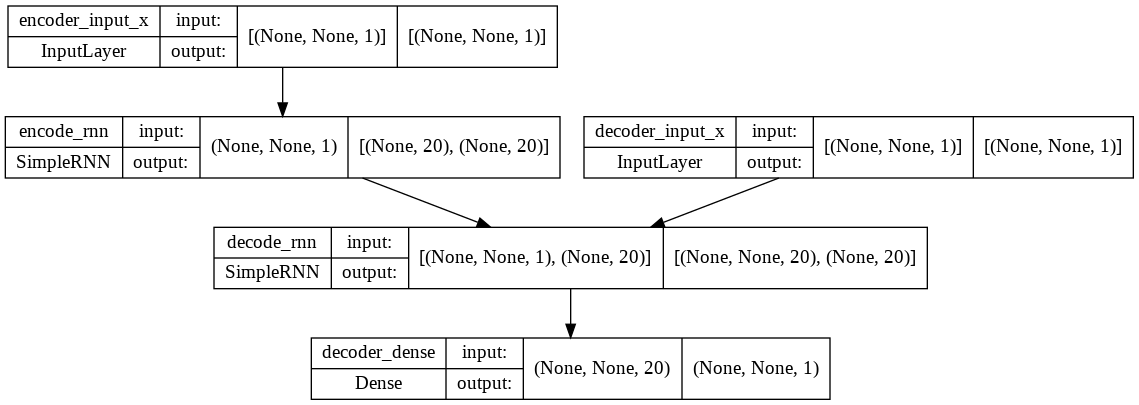

In [ ]:
# cisualize the model
tf.keras.utils.plot_model( seq2seq_model, "RNN_ex6_trainmodel.png", show_shapes=True, show_dtype=False ,show_layer_names=True ,dpi=96)

### 2) create decoder-encoder for inferencing for using when imprement

Model: "encoder_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input_x (InputLayer  [(None, None, 1)]        0         
 )                                                               
                                                                 
 encode_rnn (SimpleRNN)      [(None, 20),              440       
                              (None, 20)]                        
                                                                 
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


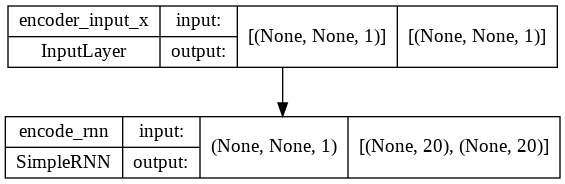

In [ ]:
# Define the encoder model for inferencing
encoder_model = tf.keras.Model( inputs=encoder_inputs, outputs=encoder_states ,name='encoder_model' )

encoder_model.summary()
tf.keras.utils.plot_model( encoder_model, "RNN_ex6_encodermodel.png", show_shapes=True, show_dtype=False ,show_layer_names=True ,dpi=96)

Model: "decoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input_x (InputLayer)   [(None, None, 1)]    0           []                               
                                                                                                  
 decoder_states_inputs (InputLa  [(None, 20)]        0           []                               
 yer)                                                                                             
                                                                                                  
 decode_rnn (SimpleRNN)         [(None, None, 20),   440         ['decoder_input_x[0][0]',        
                                 (None, 20)]                      'decoder_states_inputs[0][0]']  
                                                                                      

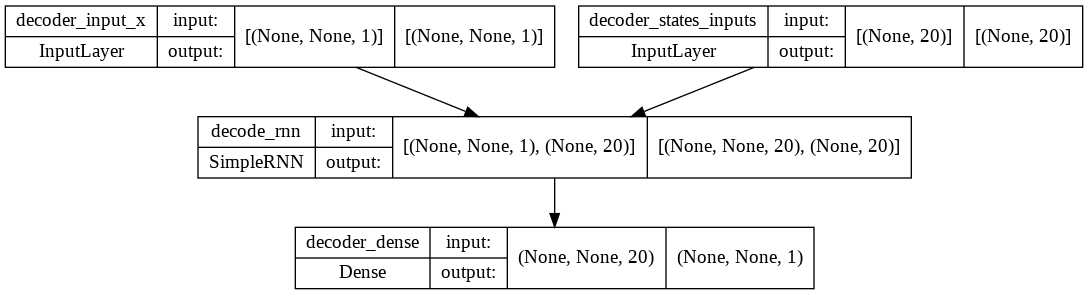

In [ ]:
# define the decoder model for inferencing
## Create a new input layer to be use during inferencing
decoder_states_inputs = tf.keras.layers.Input( shape=(n_units), name='decoder_states_inputs' )

## link all layer
decoder_outputs,decoder_states = decoder_rnn( decoder_inputs, initial_state=decoder_states_inputs)
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = tf.keras.Model( inputs=[decoder_inputs]+[decoder_states_inputs],
                               outputs=[decoder_outputs]+[decoder_states],
                               name="decoder_model")

decoder_model.summary()
tf.keras.utils.plot_model( decoder_model, "RNN_ex6_decodermodel.png", show_shapes=True, show_dtype=False ,show_layer_names=True ,dpi=96)


## 6.2 Prepare data with one-step output

to train the unified ***seq2seq_model*** model, we need to prepare the following inputs and outputs:


*   input1 : encoder_input_x : an input sequence for the encoder (later we will refer to it sas ***encoder_x***)
*   input2 : decoder_input_x an input sequence for the decoder (later we will refer to it sas ***decoder_x***)
*   output : decode_dense.output a prediction output of decoder (later we will refer to it sas ***decoder_y***)

values of encoder_x and decoder_y are straightforward. For example, one training sampling with 5-step inputs and 3-step prediction output will be link encder_x[i] = [2,4,6,8,10] and decoder_y[i] = [12,14,16] 

the one whose calue need additional consideration is decoder_x. Here we use ***Teacher Forcing***, the popular training technique in meching translation, so if encder_x[i] = [2,4,6,8,10] and decoder_y[i] = [12,14,16] then decoder_x[i] = ['<\s>',12,14]

### 1 Genarate squence data

In [ ]:
n_data = 2000 #Number of genarate data

#TimeseriesGenerator
sampling_rate = 2     #for 2 consecutive numbers, sample only one
n_input_timesteps = 5 #How many timestep for the input sequence

dataset = np.array([ i for i in range(n_data*-sampling_rate, n_data*sampling_rate)])

gen_dataset = tf.keras.preprocessing.sequence.TimeseriesGenerator( dataset, dataset, length=sampling_rate*n_input_timesteps, batch_size=n_data, sampling_rate=sampling_rate)

x, y = gen_dataset[0]

In [ ]:
#Preview the first five rows and the last five rows
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-4000 -3998 -3996 -3994 -3992] , -3990
1 : [-3999 -3997 -3995 -3993 -3991] , -3989
2 : [-3998 -3996 -3994 -3992 -3990] , -3988
3 : [-3997 -3995 -3993 -3991 -3989] , -3987
4 : [-3996 -3994 -3992 -3990 -3988] , -3986
-1 : [-2001 -1999 -1997 -1995 -1993] , -1991
-2 : [-2002 -2000 -1998 -1996 -1994] , -1992
-3 : [-2003 -2001 -1999 -1997 -1995] , -1993
-4 : [-2004 -2002 -2000 -1998 -1996] , -1994
-5 : [-2005 -2003 -2001 -1999 -1997] , -1995


In [ ]:
#Shuffle the data (before splitting it in to train/val/test sets later inthe next cell)

#Shuffle the data
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(x)

rng = np.random.RandomState(seed)
rng.shuffle(y)

# Preview the first five rows of data
print(f"x-shape:{x.shape}, y-shape:{y.shape}")
for i in range(5):
  print(f"{i} : {x[i]} , {y[i]}")
for i in range(-1, -6, -1):
  print(f"{i} : {x[i]} , {y[i]}")

x-shape:(2000, 5), y-shape:(2000,)
0 : [-3033 -3031 -3029 -3027 -3025] , -3023
1 : [-3372 -3370 -3368 -3366 -3364] , -3362
2 : [-3423 -3421 -3419 -3417 -3415] , -3413
3 : [-3911 -3909 -3907 -3905 -3903] , -3901
4 : [-2829 -2827 -2825 -2823 -2821] , -2819
-1 : [-2825 -2823 -2821 -2819 -2817] , -2815
-2 : [-3811 -3809 -3807 -3805 -3803] , -3801
-3 : [-3140 -3138 -3136 -3134 -3132] , -3130
-4 : [-2744 -2742 -2740 -2738 -2736] , -2734
-5 : [-2809 -2807 -2805 -2803 -2801] , -2799


In [ ]:
n_train = int(n_data * 0.8)       # Split 80% to train set
n_test = int(n_data * 0.1)        # Split 10% to test set
n_val = n_data -n_train -n_test   # 10% to validate set

encoder_x_train, ynext_train = x[:n_train] , y[:n_train] 
encoder_x_val, ynext_val = x[n_train:n_train+n_val], y[n_train:n_train+n_val]
encoder_x_test, ynext_test = x[n_train+n_val:], y[n_train+n_val:]

print("\n===== Train data =====")
print(f"x_train-shape:{encoder_x_train.shape}, y_train-shape:{ynext_train.shape}")
for i in range(5):
  print(f"{i} x:{encoder_x_train[i]}, y:{ynext_train[i]}")

print("\n===== Validation data =====")
print(f"x_val-shape:{encoder_x_val.shape}, y_val-shape:{ynext_val.shape}")
for i in range(5):
  print(f"{i} x:{encoder_x_val[i]}, y:{ynext_val[i]}")

print("\n===== Test data =====")
print(f"x_test-shape:{encoder_x_test.shape}, y_test-shape:{ynext_test.shape}")
for i in range(5):
  print(f"{i} x:{encoder_x_test[i]}, y:{ynext_test[i]}")


===== Train data =====
x_train-shape:(1600, 5), y_train-shape:(1600,)
0 x:[-3033 -3031 -3029 -3027 -3025], y:-3023
1 x:[-3372 -3370 -3368 -3366 -3364], y:-3362
2 x:[-3423 -3421 -3419 -3417 -3415], y:-3413
3 x:[-3911 -3909 -3907 -3905 -3903], y:-3901
4 x:[-2829 -2827 -2825 -2823 -2821], y:-2819

===== Validation data =====
x_val-shape:(200, 5), y_val-shape:(200,)
0 x:[-3200 -3198 -3196 -3194 -3192], y:-3190
1 x:[-3488 -3486 -3484 -3482 -3480], y:-3478
2 x:[-2285 -2283 -2281 -2279 -2277], y:-2275
3 x:[-3846 -3844 -3842 -3840 -3838], y:-3836
4 x:[-2724 -2722 -2720 -2718 -2716], y:-2714

===== Test data =====
x_test-shape:(200, 5), y_test-shape:(200,)
0 x:[-2126 -2124 -2122 -2120 -2118], y:-2116
1 x:[-3343 -3341 -3339 -3337 -3335], y:-3333
2 x:[-3710 -3708 -3706 -3704 -3702], y:-3700
3 x:[-3995 -3993 -3991 -3989 -3987], y:-3985
4 x:[-2885 -2883 -2881 -2879 -2877], y:-2875


### 2 Prepare the 3-step output (decoder_y)

In [ ]:
n_output_timesteps = 3 #how many time step a head to predict

#Create decoder_y from ynext
decoder_y_train = np.zeros( (ynext_train.shape[0],n_output_timesteps), dtype=ynext_train.dtype)
decoder_y_test  = np.zeros( (ynext_test.shape[0],n_output_timesteps) , dtype=ynext_test.dtype)
decoder_y_val   = np.zeros( (ynext_val.shape[0],n_output_timesteps)  , dtype=ynext_val.dtype)

#Copy original value to vector
decoder_y_train[:,0] = ynext_train[:]
decoder_y_test[:,0]  = ynext_test[:]
decoder_y_val[:,0]   = ynext_val[:]

print(decoder_y_train[0])

[-3023     0     0]


In [ ]:
# Compute values for the 1stand 2nd columns of each array
for i in range(1,n_output_timesteps):
  decoder_y_train[:,i] = decoder_y_train[:,i-1] +2
  decoder_y_test[:,i]  = decoder_y_test[:,i-1] +2
  decoder_y_val[:,i]   = decoder_y_val[:,i-1] +2

print(decoder_y_train[0])

[-3023 -3021 -3019]


In [ ]:
# Preview Before-After result
print(f"\n========== y_train ==========")
print(f"Shape before:{ynext_train.shape} after:{decoder_y_train.shape}")
print(f"Example befor : {ynext_train[0]} , after ; {decoder_y_train[0]}")

print(f"\n========== y_test ==========")
print(f"Shape before:{ynext_test.shape} after:{decoder_y_test.shape}")
print(f"Example befor : {ynext_test[0]} , after ; {decoder_y_test[0]}")

print(f"\n========== y_val ==========")
print(f"Shape before:{ynext_val.shape} after:{decoder_y_val.shape}")
print(f"Example befor : {ynext_val[0]} , after ; {decoder_y_val[0]}")


========== y_train ==========
Shape before:(1600,) after:(1600, 3)
Example befor : -3023 , after ; [-3023 -3021 -3019]

========== y_test ==========
Shape before:(200,) after:(200, 3)
Example befor : -2116 , after ; [-2116 -2114 -2112]

========== y_val ==========
Shape before:(200,) after:(200, 3)
Example befor : -3190 , after ; [-3190 -3188 -3186]


### 3 Normalize the data

In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling to normalize the data to range [0, 1]
#.fit_transfrom expects 2D input
minmax_norm = MinMaxScaler().fit(encoder_x_train.reshape(-1,1))
print(f"Dataset min-max: {minmax_norm.data_min_}, {minmax_norm.data_max_}")

encoder_x_train_norm = minmax_norm.transform( encoder_x_train.reshape(-1,1)).reshape(encoder_x_train.shape)
decoder_y_train_norm = minmax_norm.transform( decoder_y_train.reshape(-1,1)).reshape(decoder_y_train.shape)

encoder_x_val_norm = minmax_norm.transform( encoder_x_val.reshape(-1,1)).reshape(encoder_x_val.shape)
decoder_y_val_norm = minmax_norm.transform( decoder_y_val.reshape(-1,1)).reshape(decoder_y_val.shape)

encoder_x_test_norm = minmax_norm.transform( encoder_x_test.reshape(-1,1)).reshape(encoder_x_test.shape)
decoder_y_test_norm = minmax_norm.transform( decoder_y_test.reshape(-1,1)).reshape(decoder_y_test.shape)


Dataset min-max: [-4000.], [-1993.]


In [ ]:
#Format the data into (batch_size, time_step, input_dim) as required by the SimpleRNN layer
print("\n===== Train data after normalization (encoder_x,decoder_y) =====")
print(f"x_train_norm:{encoder_x_train_norm.shape}, y_train_norm:{decoder_y_train_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_train_norm[i]} , {decoder_y_train_norm[i]}")

print("\n===== Validation data after normalization (encoder_x,decoder_y) =====")
print(f"x_val_norm:{encoder_x_val_norm.shape}, y_val_norm:{decoder_y_val_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_val_norm[i]} , {decoder_y_val_norm[i]}")

print("\n===== Test data after normalization (encoder_x,decoder_y) =====")
print(f"x_test_norm:{encoder_x_test_norm.shape}, y_test_norm:{decoder_y_test_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_test_norm[i]} , {decoder_y_test_norm[i]}")



===== Train data after normalization (encoder_x,decoder_y) =====
x_train_norm:(1600, 5), y_train_norm:(1600, 3)
0 : [0.48181365 0.48281016 0.48380668 0.48480319 0.4857997 ] , [0.48679621 0.48779273 0.48878924]
1 : [0.31290483 0.31390135 0.31489786 0.31589437 0.31689088] , [0.31788739 0.31888391 0.31988042]
2 : [0.28749377 0.28849028 0.2894868  0.29048331 0.29147982] , [0.29247633 0.29347285 0.29446936]
3 : [0.04434479 0.04534131 0.04633782 0.04733433 0.04833084] , [0.04932735 0.05032387 0.05132038]
4 : [0.5834579  0.58445441 0.58545092 0.58644743 0.58744395] , [0.58844046 0.58943697 0.59043348]

===== Validation data after normalization (encoder_x,decoder_y) =====
x_val_norm:(200, 5), y_val_norm:(200, 3)
0 : [0.39860488 0.3996014  0.40059791 0.40159442 0.40259093] , [0.40358744 0.40458396 0.40558047]
1 : [0.25510713 0.25610364 0.25710015 0.25809666 0.25909317] , [0.26008969 0.2610862  0.26208271]
2 : [0.85450922 0.85550573 0.85650224 0.85749875 0.85849527] , [0.85949178 0.86048829 0.8

### 4 Prepare the decoder's input (decoder_x) according to Teacher forcing

In [ ]:
def gen_decoder_x(decoder_ytrain, decoder_ytest, decoder_yval, start_token=-0.1):
  # Initial all with zero
  decoder_xtrain = np.zeros_like(decoder_ytrain)
  decoder_xtest  = np.zeros_like(decoder_ytest)
  decoder_xval   = np.zeros_like(decoder_yval)

  #set the stert token for the first time step
  decoder_xtrain[:,0] = start_token
  decoder_xtest[:,0]  = start_token
  decoder_xval[:,0]   = start_token

  # Teacher forcing
  n_timesteps = decoder_ytrain.shape[-1]
  decoder_xtrain[:,1:] = decoder_ytrain[:, 0:n_timesteps-1]
  decoder_xtest[:,1:]  = decoder_ytest[:, 0:n_timesteps-1]
  decoder_xval[:,1:]   = decoder_yval[:, 0:n_timesteps-1]

  return decoder_xtrain,decoder_xtest,decoder_xval

In [ ]:
start_token = -0.01 # the start of sequence for teacher forcing
gen_results = gen_decoder_x(decoder_y_train_norm, decoder_y_test_norm, decoder_y_val_norm, start_token)
decoder_x_train_norm, decoder_x_test_norm, decoder_X_val_norm = gen_results

print(decoder_x_train_norm[0])

[-0.01        0.48679621  0.48779273]


In [ ]:
print(f"****** use teacher forcing with start_token={start_token:.2f} for decoder_x ******")
print(f"\n ======= decoder_x_train_norm =======")
print(f" shape:{decoder_x_train_norm.shape} dacoder_y:{decoder_y_train_norm[0]} ==> decoder_x:{decoder_x_train_norm[0]}")
print(f"\n ======= decoder_x_test_norm =======")
print(f" shape:{decoder_x_test_norm.shape} dacoder_y:{decoder_y_test_norm[0]} ==> decoder_x:{decoder_x_test_norm[0]}")
print(f"\n ======= decoder_X_val_norm =======")
print(f" shape:{decoder_X_val_norm.shape} dacoder_y:{decoder_y_val_norm[0]} ==> decoder_x:{decoder_X_val_norm[0]}")

****** use teacher forcing with start_token=-0.01 for decoder_x ******

 ======= decoder_x_train_norm =======
 shape:(1600, 3) dacoder_y:[0.48679621 0.48779273 0.48878924] ==> decoder_x:[-0.01        0.48679621  0.48779273]

 ======= decoder_x_test_norm =======
 shape:(200, 3) dacoder_y:[0.9387145  0.93971101 0.94070752] ==> decoder_x:[-0.01        0.9387145   0.93971101]

 ======= decoder_X_val_norm =======
 shape:(200, 3) dacoder_y:[0.40358744 0.40458396 0.40558047] ==> decoder_x:[-0.01        0.40358744  0.40458396]


### 5 Set Format data according to seq2seq_model's requiremants

In [ ]:
print(f"{'#'*10} Dimension before changed {'#'*10}")
print(f"encoder_x_train_norm: {encoder_x_train_norm.shape} ,decoder_x_train_norm: {decoder_x_train_norm.shape} ,decoder_y_train_norm: {decoder_y_train_norm.shape}")
print(f"encoder_x_test_norm: {encoder_x_test_norm.shape} ,decoder_x_test_norm: {decoder_x_test_norm.shape} ,decoder_y_test_norm: {decoder_y_test_norm.shape}")
print(f"encoder_x_val_norm: {encoder_x_val_norm.shape} ,decoder_X_val_norm: {decoder_X_val_norm.shape} ,decoder_y_val_norm: {decoder_y_val_norm.shape}")


########## Dimension before changed ##########
encoder_x_train_norm: (1600, 5) ,decoder_x_train_norm: (1600, 3) ,decoder_y_train_norm: (1600, 3)
encoder_x_test_norm: (200, 5) ,decoder_x_test_norm: (200, 3) ,decoder_y_test_norm: (200, 3)
encoder_x_val_norm: (200, 5) ,decoder_X_val_norm: (200, 3) ,decoder_y_val_norm: (200, 3)


In [ ]:
encoder_x_train_norm = np.expand_dims(encoder_x_train_norm, axis=2)
encoder_x_test_norm = np.expand_dims(encoder_x_test_norm, axis=2)
encoder_x_val_norm = np.expand_dims(encoder_x_val_norm, axis=2)

decoder_x_train_norm = np.expand_dims(decoder_x_train_norm, axis=2)
decoder_x_test_norm = np.expand_dims(decoder_x_test_norm, axis=2)
decoder_X_val_norm = np.expand_dims(decoder_X_val_norm, axis=2)

decoder_y_train_norm = np.expand_dims(decoder_y_train_norm, axis=2)
decoder_y_test_norm = np.expand_dims(decoder_y_test_norm, axis=2)
decoder_y_val_norm = np.expand_dims(decoder_y_val_norm, axis=2)

In [ ]:
print(f"{'#'*10} Dimension After changed {'#'*10}")
print(f"encoder_x_train_norm: {encoder_x_train_norm.shape} ,decoder_x_train_norm: {decoder_x_train_norm.shape} ,decoder_y_train_norm: {decoder_y_train_norm.shape}")
print(f"encoder_x_test_norm: {encoder_x_test_norm.shape} ,decoder_x_test_norm: {decoder_x_test_norm.shape} ,decoder_y_test_norm: {decoder_y_test_norm.shape}")
print(f"encoder_x_val_norm: {encoder_x_val_norm.shape} ,decoder_X_val_norm: {decoder_X_val_norm.shape} ,decoder_y_val_norm: {decoder_y_val_norm.shape}")


########## Dimension After changed ##########
encoder_x_train_norm: (1600, 5, 1) ,decoder_x_train_norm: (1600, 3, 1) ,decoder_y_train_norm: (1600, 3, 1)
encoder_x_test_norm: (200, 5, 1) ,decoder_x_test_norm: (200, 3, 1) ,decoder_y_test_norm: (200, 3, 1)
encoder_x_val_norm: (200, 5, 1) ,decoder_X_val_norm: (200, 3, 1) ,decoder_y_val_norm: (200, 3, 1)


In [ ]:
# Covert everything to the drfult of float32
encoder_x_train_norm = encoder_x_train_norm.astype(np.float32)
encoder_x_test_norm = encoder_x_test_norm.astype(np.float32)
encoder_x_val_norm = encoder_x_val_norm.astype(np.float32)

decoder_x_train_norm = decoder_x_train_norm.astype(np.float32)
decoder_x_test_norm = decoder_x_test_norm.astype(np.float32)
decoder_X_val_norm = decoder_X_val_norm.astype(np.float32)

decoder_y_train_norm = decoder_y_train_norm.astype(np.float32)
decoder_y_test_norm = decoder_y_test_norm.astype(np.float32)
decoder_y_val_norm = decoder_y_val_norm.astype(np.float32)

In [ ]:
encoder_x_train_norm[0].ravel()

array([0.48181364, 0.48281017, 0.48380667, 0.4848032 , 0.4857997 ],
      dtype=float32)

In [ ]:
print("\n===== Train data =====")
print(f"encoder_x_train_norm:{encoder_x_train_norm.shape}, decoder_y_train_norm:{decoder_y_train_norm.shape}, decoder_x_train_norm:{decoder_x_train_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_train_norm[i].ravel()} , {decoder_y_train_norm[i].ravel()} , {decoder_x_train_norm[i].ravel()}")

print("\n===== Validation data =====")
print(f"encoder_x_val_norm:{encoder_x_val_norm.shape}, decoder_y_val_norm:{decoder_y_val_norm.shape}, decoder_x_test_norm:{decoder_x_test_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_val_norm[i].ravel()} , {decoder_y_val_norm[i].ravel()} , {decoder_x_test_norm[i].ravel()}")

print("\n===== Test data =====")
print(f"encoder_x_test_norm:{encoder_x_test_norm.shape}, decoder_y_test_norm:{decoder_y_test_norm.shape}, decoder_X_val_norm:{decoder_X_val_norm.shape}")
for i in range(5):
  print(f"{i} : {encoder_x_test_norm[i].ravel()} , {decoder_y_test_norm[i].ravel()} , {decoder_X_val_norm[i].ravel()}")



===== Train data =====
encoder_x_train_norm:(1600, 5, 1), decoder_y_train_norm:(1600, 3, 1), decoder_x_train_norm:(1600, 3, 1)
0 : [0.48181364 0.48281017 0.48380667 0.4848032  0.4857997 ] , [0.4867962  0.48779273 0.48878923] , [-0.01        0.4867962   0.48779273]
1 : [0.31290483 0.31390134 0.31489787 0.31589437 0.3168909 ] , [0.3178874  0.3188839  0.31988043] , [-0.01       0.3178874  0.3188839]
2 : [0.28749377 0.2884903  0.2894868  0.2904833  0.29147983] , [0.29247633 0.29347286 0.29446936] , [-0.01        0.29247633  0.29347286]
3 : [0.04434479 0.04534131 0.04633782 0.04733433 0.04833084] , [0.04932735 0.05032387 0.05132038] , [-0.01        0.04932735  0.05032387]
4 : [0.5834579  0.5844544  0.58545095 0.5864474  0.58744395] , [0.5884405  0.58943695 0.5904335 ] , [-0.01        0.5884405   0.58943695]

===== Validation data =====
encoder_x_val_norm:(200, 5, 1), decoder_y_val_norm:(200, 3, 1), decoder_x_test_norm:(200, 3, 1)
0 : [0.39860487 0.3996014  0.4005979  0.40159443 0.40259093]

## 6.3 Complie and Train the model

In [ ]:
checkpoint_filepath = "RNN_ex6_bestmodel_epoch{epoch:03d}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                               save_weights_only=False,
                                                               monitor='val_loss',
                                                               mode='min',
                                                               save_best_only=True)

Keras's callback can only save the unified seq2seq_model model not the two separated model (encoder_model and decoder_model) that share the same computational graph as seq2seq_model's 

So we have to subclass tf.keras.call.backs to save the best encoder_model and decoder_model models outselves at the end of each epoch.

In [ ]:
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, encoder, decoder):
    super().__init__()

    #The encoder and Decoder model to be save
    self.encoder = encoder
    self.decoder = decoder
    self.start_time = None
    self.min_valloss = None
    

  def on_train_begin(self, logs=None):
    self.start_time = time.time()
    self.min_valloss = None

  def on_epoch_end(self, epoch, logs=None):
    # compute the totla runtime since the trainig started
    total_run_time =int(time.time() - self.start_time)
    msg = f" Train time{datetime.timedelta(seconds=total_run_time)}"

    #Save the best encoder and decoder models
    if 'val_loss' in logs.keys():
      if self.min_valloss is None:
        self.min_valloss = logs['val_loss']
      if logs['val_loss'] < self.min_valloss:
        self.min_valloss = logs['val_loss']
        self.encoder.save("RNN_ex6_bestencoder.hdf5")
        self.decoder.save("RNN_ex6_bestdecoder.hdf5")
        msg += "**best**"
    
    # Print total run time at the beginning of each epoh's log
    print( msg, end='-')

my_cellback = CustomCallback(encoder_model, decoder_model)

### Compile and Train

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
seq2seq_model.compile( loss="mse", optimizer=adam, metrics=["mean_absolute_error"] )

In [ ]:
# Supress TF's warning messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
hist_ex6 = seq2seq_model.fit( [encoder_x_train_norm, decoder_x_train_norm], decoder_y_train_norm, 
                             validation_data=([encoder_x_val_norm, decoder_X_val_norm], decoder_y_val_norm),
                             batch_size=64, epochs=500, callbacks=[model_checkpoint_callback, my_cellback],
                             verbose=2
                             )

Epoch 1/500
 Train time0:00:04-25/25 - 4s - loss: 0.3372 - mean_absolute_error: 0.4448 - val_loss: 0.0473 - val_mean_absolute_error: 0.1866 - 4s/epoch - 159ms/step
Epoch 2/500
 Train time0:00:04**best**-25/25 - 0s - loss: 0.0443 - mean_absolute_error: 0.1825 - val_loss: 0.0225 - val_mean_absolute_error: 0.1248 - 184ms/epoch - 7ms/step
Epoch 3/500
 Train time0:00:04**best**-25/25 - 0s - loss: 0.0179 - mean_absolute_error: 0.1105 - val_loss: 0.0093 - val_mean_absolute_error: 0.0818 - 184ms/epoch - 7ms/step
Epoch 4/500
 Train time0:00:04**best**-25/25 - 0s - loss: 0.0075 - mean_absolute_error: 0.0716 - val_loss: 0.0045 - val_mean_absolute_error: 0.0552 - 190ms/epoch - 8ms/step
Epoch 5/500
 Train time0:00:04**best**-25/25 - 0s - loss: 0.0047 - mean_absolute_error: 0.0552 - val_loss: 0.0034 - val_mean_absolute_error: 0.0461 - 187ms/epoch - 7ms/step
Epoch 6/500
 Train time0:00:04**best**-25/25 - 0s - loss: 0.0038 - mean_absolute_error: 0.0491 - val_loss: 0.0027 - val_mean_absolute_error: 0.0

In [ ]:
hist_ex6.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

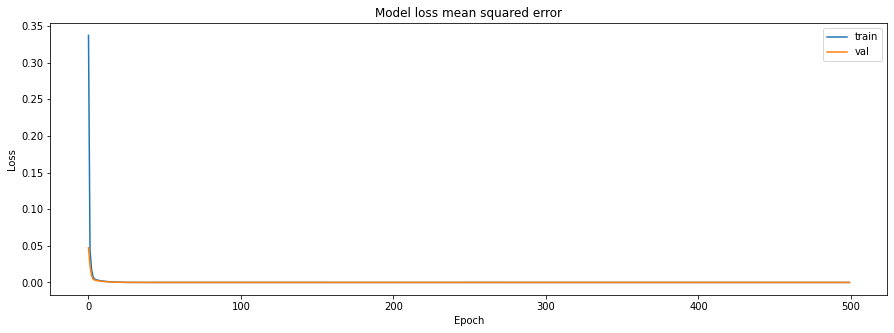

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex6.history['loss'])
plt.plot( hist_ex6.history['val_loss'])
plt.title('Model loss mean squared error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

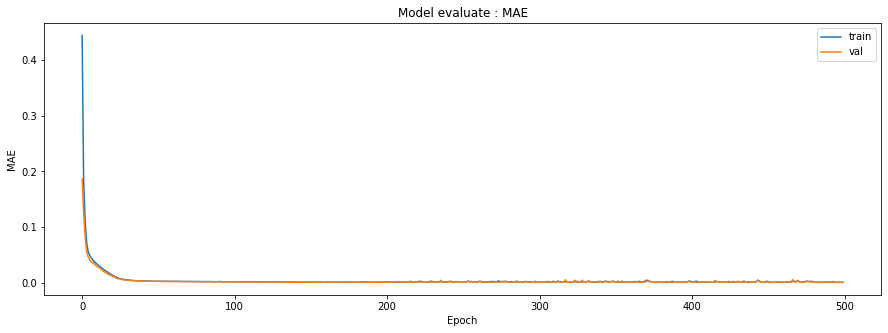

In [ ]:
#Plot training and validation loss values
plt.figure(figsize=(15,5))
plt.plot( hist_ex6.history['mean_absolute_error'])
plt.plot( hist_ex6.history['val_mean_absolute_error'])
plt.title('Model evaluate : MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper right')
plt.show()

## 6.4 Evaluation

In actual inferencing, the unified model of **seq2seq_model** is no use but **encoder_model** and ***decoder_model*** are bot applied for autoregressive decoding. Hence, the actual model evaluation should be done in the autoregressive manner like in Inference section

In [ ]:
# Load the model from the best epoch (minimum val_loss)
bestmodel_file = max([ f for f in os.listdir(".") if f.startswith('RNN_ex6_bestmodel_') and f.endswith(".hdf5")])
print( f"The best model : {bestmodel_file}")

The best model : RNN_ex6_bestmodel_epoch496.hdf5


In [ ]:
ex6_rnn_best = tf.keras.models.load_model(bestmodel_file, compile=True )

In [ ]:
#Evaluate the model from last epoch
score = seq2seq_model.evaluate([encoder_x_test_norm, decoder_x_test_norm], decoder_y_test_norm, verbose=0)
if hasattr(score,'__len__'):  
  print(f"Test results (model from the last epoch) :{[(seq2seq_model.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the last epoch) :{[(seq2seq_model.metrics_names[0],score)]}")

Test results (model from the last epoch) :[('loss', 4.556383714771073e-07), ('mean_absolute_error', 0.000543230795301497)]


In [ ]:
#Evaluate the model from best epoch
score = ex6_rnn_best.evaluate([encoder_x_test_norm, decoder_x_test_norm], decoder_y_test_norm, verbose=0)
if hasattr(score,'__len__'):
  print(f"Test results (model from the best epoch) :{[(ex6_rnn_best.metrics_names[i],score[i]) for i in range(len(score))]}")
else :
   print(f"Test results (model from the best epoch) :{[(ex6_rnn_best.metrics_names[0],score)]}")

Test results (model from the best epoch) :[('loss', 2.2060039839288947e-07), ('mean_absolute_error', 0.0003713608894031495)]


## 6.5 Inference

### Load the best encoder and decoder model

In [ ]:
# Load the encoder and decoder models corresponding to best epoch (minimum val_loss)
best_encoder = tf.keras.models.load_model(f"RNN_ex6_bestencoder.hdf5", compile=False)
best_decoder = tf.keras.models.load_model(f"RNN_ex6_bestdecoder.hdf5", compile=False)

### Define a fuction for autoregressive decoding

In [ ]:
def autoregressive_decode( encoder_inf, decoder_inf, input_seq, n_step_out, n_out_feature=1, start_token=0):
  """
  Input arguments:
    endcoder_inf (model) : the encoder model to be used during inferencing
    decoder_inf (model)  : the decoder model to be used during inferencing
    input_seq (a sequence of numbers) : an input sequence (input_dim=1) for the model to predit the next numbers
    n_step_out (int) : for how the number of features for one output (in our example)
    n_out_feature (int) : the number of feature for one output (in out example, it is 1)
  """
  # Encode
  state = encoder_inf.predict(input_seq)

  # Create the first input of the decoder (= the start token)
  target_seq = np.zeros(n_out_feature).reshape(1, 1, n_out_feature)
  target_seq[0, 0, :] = start_token

  # Collect prediction from autoregressive decoding
  output = []
  for i in range(n_step_out):
    # Predict the next number
    y_pred, state = decoder_inf.predict( [target_seq, state] )

    # Store prediction
    output.append( y_pred[0, 0, :] )

    # Update target sequence
    target_seq =y_pred

  return np.array( output )


### Use auoregression decoding

Evaluate the models on the train set

In [ ]:
n = 10 # evaluate the first n data of train set
mae_loss_norm = 0.0
mae_loss = 0.0
n_step_out = n_output_timesteps #Here we use the same timesteps as in decoder_y for easy loss evaluation

for i in range(n):
  ypred_norm = autoregressive_decode( best_encoder, best_decoder, 
                                     np.expand_dims( encoder_x_train_norm[i], axis=0),
                                     n_step_out,
                                     1,
                                     start_token)
  ypred = minmax_norm.inverse_transform(ypred_norm)
  
  mae_loss_norm += np.absolute(ypred_norm - decoder_y_train_norm[i]).sum(axis=None)
  mae_loss += np.absolute( ypred - decoder_y_train[i] ).sum(axis=None)

  print(f"encoder_x_train[{i}] => {encoder_x_train[i]}, decoder_y_train[{i}] => {decoder_y_train[i]}, predict = {np.around(ypred.reshape(-1))}")

mae_loss_norm /= ( n * n_step_out )
mae_loss /= ( n * n_step_out )
print(f"Total loss (Mean absolate Error) per one sample of Normalized train data = {mae_loss_norm}")
print(f"Total loss (Mean absolate Error) per one sample of Unnormalized train data = {mae_loss}")


encoder_x_train[0] => [-3033 -3031 -3029 -3027 -3025], decoder_y_train[0] => [-3023 -3021 -3019], predict = [-3023. -3021. -3019.]
encoder_x_train[1] => [-3372 -3370 -3368 -3366 -3364], decoder_y_train[1] => [-3362 -3360 -3358], predict = [-3361. -3359. -3357.]
encoder_x_train[2] => [-3423 -3421 -3419 -3417 -3415], decoder_y_train[2] => [-3413 -3411 -3409], predict = [-3413. -3410. -3408.]
encoder_x_train[3] => [-3911 -3909 -3907 -3905 -3903], decoder_y_train[3] => [-3901 -3899 -3897], predict = [-3901. -3900. -3898.]
encoder_x_train[4] => [-2829 -2827 -2825 -2823 -2821], decoder_y_train[4] => [-2819 -2817 -2815], predict = [-2818. -2817. -2815.]
encoder_x_train[5] => [-3464 -3462 -3460 -3458 -3456], decoder_y_train[5] => [-3454 -3452 -3450], predict = [-3453. -3451. -3449.]
encoder_x_train[6] => [-2288 -2286 -2284 -2282 -2280], decoder_y_train[6] => [-2278 -2276 -2274], predict = [-2277. -2275. -2273.]
encoder_x_train[7] => [-3808 -3806 -3804 -3802 -3800], decoder_y_train[7] => [-3798

Evaluate the models on the test set

In [ ]:
n = 10 # evaluate the first n data of train set
mae_loss_norm = 0.0
mae_loss = 0.0
n_step_out = n_output_timesteps #Here we use the same timesteps as in decoder_y for easy loss evaluation

for i in range(n):
  ypred_norm = autoregressive_decode( best_encoder, best_decoder, 
                                     np.expand_dims( encoder_x_test_norm[i], axis=0),
                                     n_step_out,
                                     1,
                                     start_token)
  ypred = minmax_norm.inverse_transform(ypred_norm)
  
  mae_loss_norm += np.absolute(ypred_norm - decoder_y_test_norm[i]).sum(axis=None)
  mae_loss += np.absolute( ypred - decoder_y_test[i] ).sum(axis=None)

  print(f"encoder_x_test[{i}] => {encoder_x_test[i]}, decoder_y_test[{i}] => {decoder_y_test[i]}, predict = {np.around(ypred.reshape(-1))}")

mae_loss_norm /= ( n * n_step_out )
mae_loss /= ( n * n_step_out )
print(f"Total loss (Mean absolate Error) per one sample of Normalized test data = {mae_loss_norm}")
print(f"Total loss (Mean absolate Error) per one sample of Unnormalized test data = {mae_loss}")


encoder_x_test[0] => [-2126 -2124 -2122 -2120 -2118], decoder_y_test[0] => [-2116 -2114 -2112], predict = [-2116. -2115. -2112.]
encoder_x_test[1] => [-3343 -3341 -3339 -3337 -3335], decoder_y_test[1] => [-3333 -3331 -3329], predict = [-3333. -3330. -3328.]
encoder_x_test[2] => [-3710 -3708 -3706 -3704 -3702], decoder_y_test[2] => [-3700 -3698 -3696], predict = [-3700. -3698. -3696.]
encoder_x_test[3] => [-3995 -3993 -3991 -3989 -3987], decoder_y_test[3] => [-3985 -3983 -3981], predict = [-3985. -3984. -3983.]
encoder_x_test[4] => [-2885 -2883 -2881 -2879 -2877], decoder_y_test[4] => [-2875 -2873 -2871], predict = [-2875. -2874. -2872.]
encoder_x_test[5] => [-2148 -2146 -2144 -2142 -2140], decoder_y_test[5] => [-2138 -2136 -2134], predict = [-2137. -2136. -2134.]
encoder_x_test[6] => [-3022 -3020 -3018 -3016 -3014], decoder_y_test[6] => [-3012 -3010 -3008], predict = [-3012. -3010. -3009.]
encoder_x_test[7] => [-2034 -2032 -2030 -2028 -2026], decoder_y_test[7] => [-2024 -2022 -2020], p